In [1]:
import torch
import matplotlib.pyplot as plt

from torch import nn
from monai import transforms
from monai.data import CacheDataset, DataLoader
from model import UNet3D

In [2]:
data_files = [{
    'image': '../Task_Dataset/Task08_HepaticVessel/imagesTr/hepaticvessel_001.nii.gz',
    'label': '../Task_Dataset/Task08_HepaticVessel/labelsTr/hepaticvessel_001.nii.gz'
}]
state_dict = torch.load(f'./checkpoint/2509090934_UNet3D/model.pth')

In [3]:
data_trans = transforms.Compose([
    transforms.LoadImaged(keys=['image', 'label']),
    transforms.EnsureChannelFirstd(keys=['image', 'label']),
    transforms.Orientationd(keys=['image', 'label'], axcodes='RAS'),
    transforms.Spacingd(
        keys=['image', 'label'],
        pixdim=(0.8, 0.8, 1.5),
        mode=('bilinear', 'nearest')
    ),
    transforms.ScaleIntensityRanged(
        keys=['image', 'label'][0],
        a_min=-57,
        a_max=164,
        b_min=0.0,
        b_max=1.0,
        clip=True
    ),
    transforms.Resized(
        keys=['image', 'label'],
        spatial_size=(96, 96, 64)
    ),
    transforms.ToTensord(
        keys=['image', 'label']
    ),
    transforms.EnsureTyped(
        keys=['image', 'label'],
        data_type='tensor'
    )
])

In [4]:
cache = CacheDataset(data=data_files, transform=data_trans, num_workers=4)
dataloader = DataLoader(dataset=cache, num_workers=4, batch_size=1, shuffle=False)

Loading dataset: 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


In [5]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = UNet3D(1, 2, [64, 128, 256, 512], nn.BatchNorm3d, {"affine": True}).to(device)
model.load_state_dict(state_dict)
model.eval()

UNet3D(
  (in_block): DoubleConv(
    (conv1): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (encoder): ModuleList(
    (0): DownSample(
      (down): Sequential(
        (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (conv1): Sequential(
            (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          

In [6]:
data = next(iter(dataloader))

image = data['image'].to(device)
label = data['label'].to(device)
label[label > 1] = 1

from monai.inferers import sliding_window_inference
from monai.data import decollate_batch

roi_size = (96, 96, 64)
sw_batch_size = 2

post_pred = transforms.Compose([
    transforms.Activations(softmax=True),
    transforms.AsDiscrete(argmax=True),
    transforms.KeepLargestConnectedComponent(applied_labels=[1]),
    transforms.AsDiscrete(to_onehot=2)
])
post_label = transforms.Compose([
    transforms.AsDiscrete(to_onehot=2),
    transforms.ToTensor(),
    transforms.EnsureType(data_type='tensor')
])

with torch.no_grad():
    valid_out = sliding_window_inference(image, roi_size, sw_batch_size, model)
    valid_out = [post_pred(i) for i in decollate_batch(valid_out)]

label = [post_label(i) for i in decollate_batch(label)]
valid_out, label = valid_out[0], label[0]

In [7]:
valid_out = torch.argmax(valid_out, dim=0)
label = torch.argmax(label, dim=0)

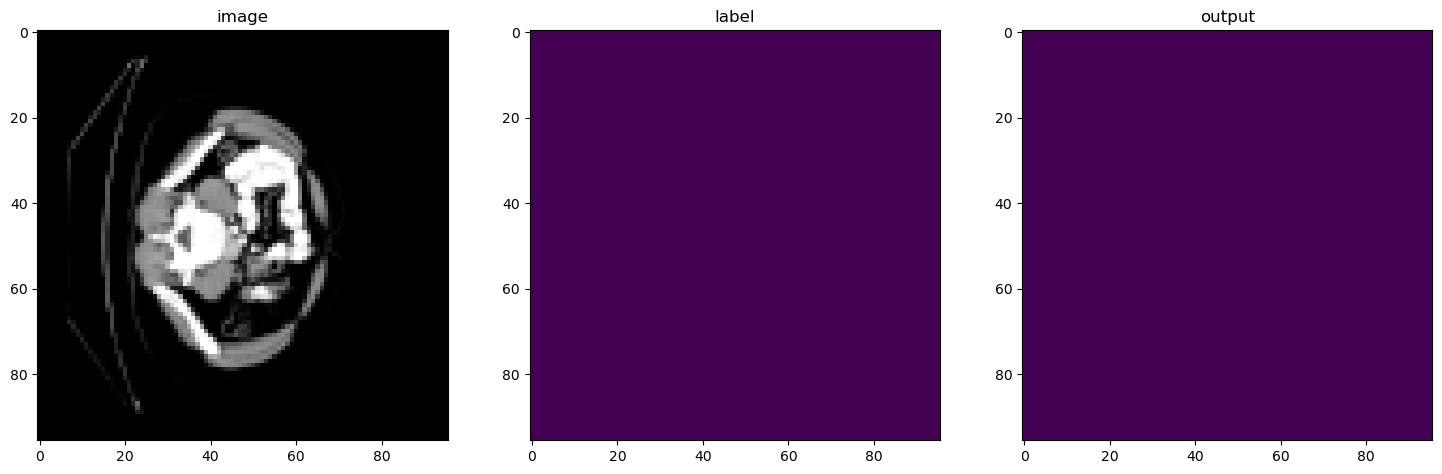

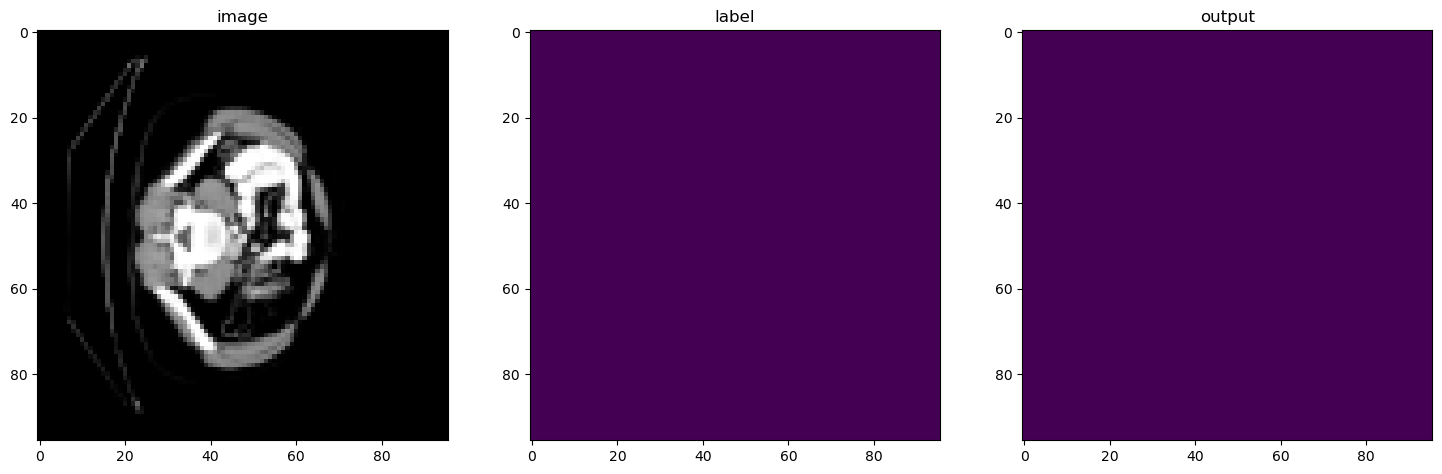

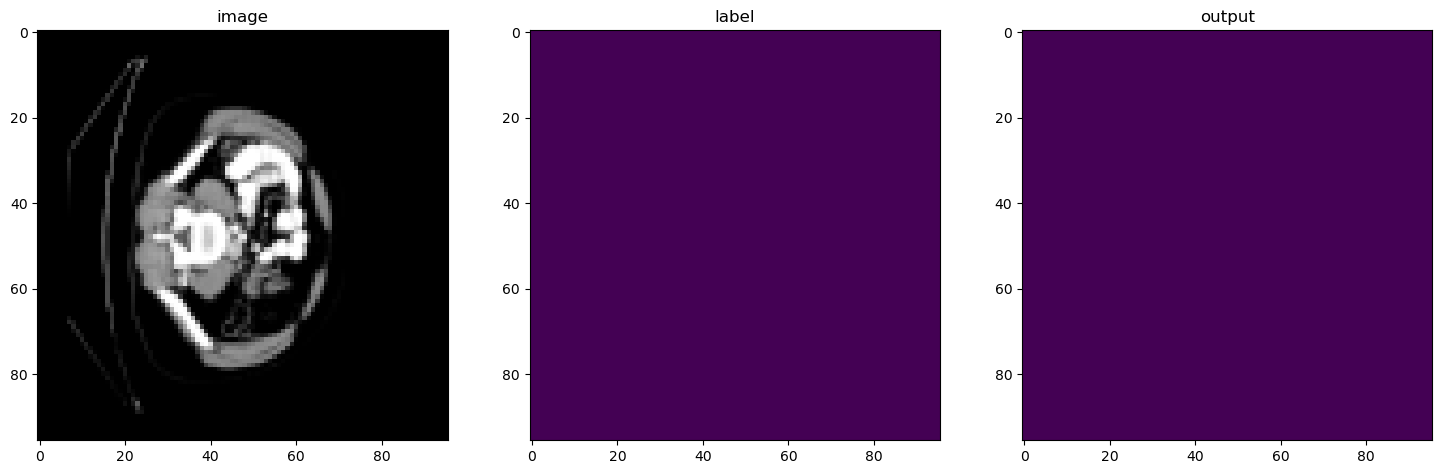

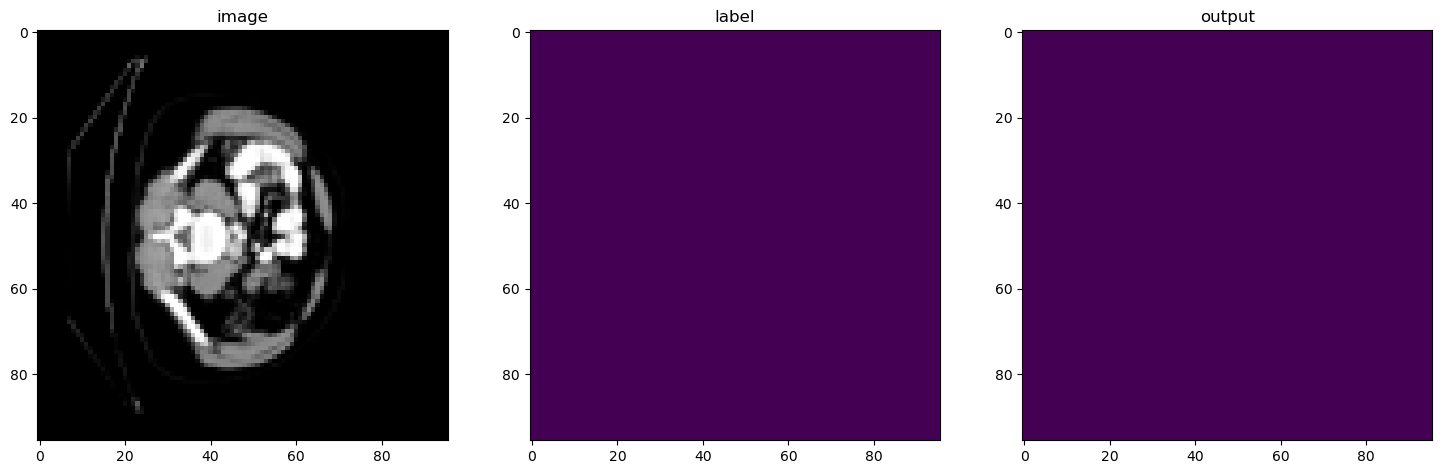

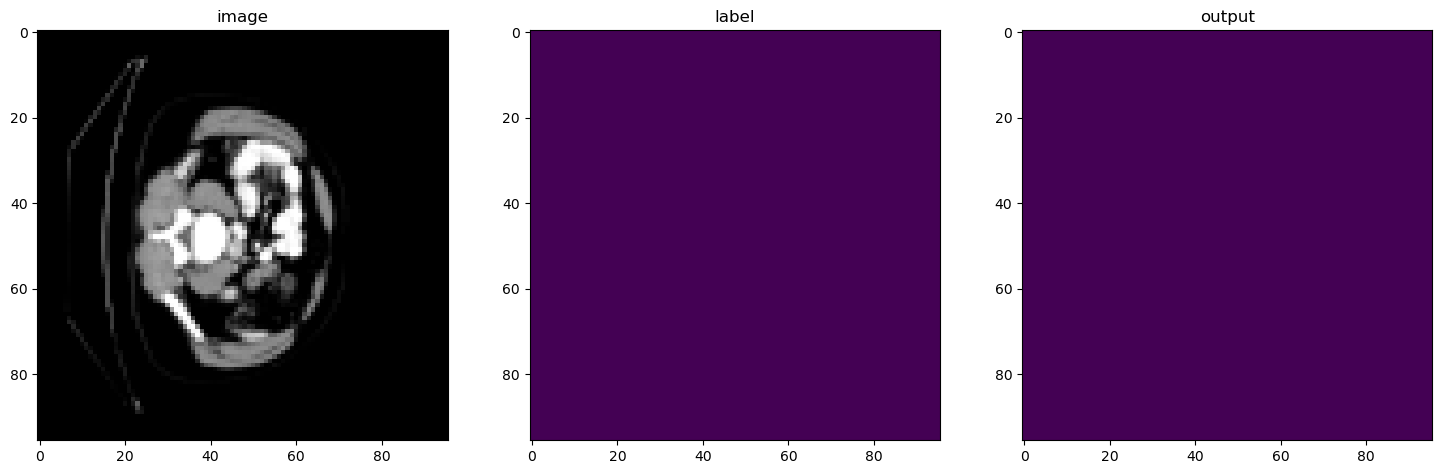

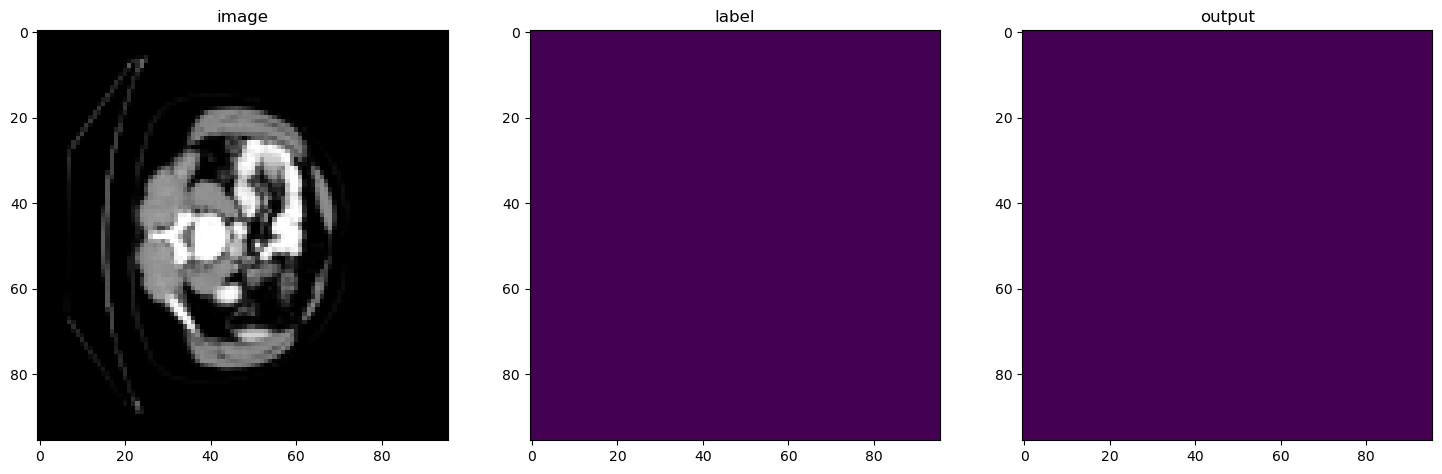

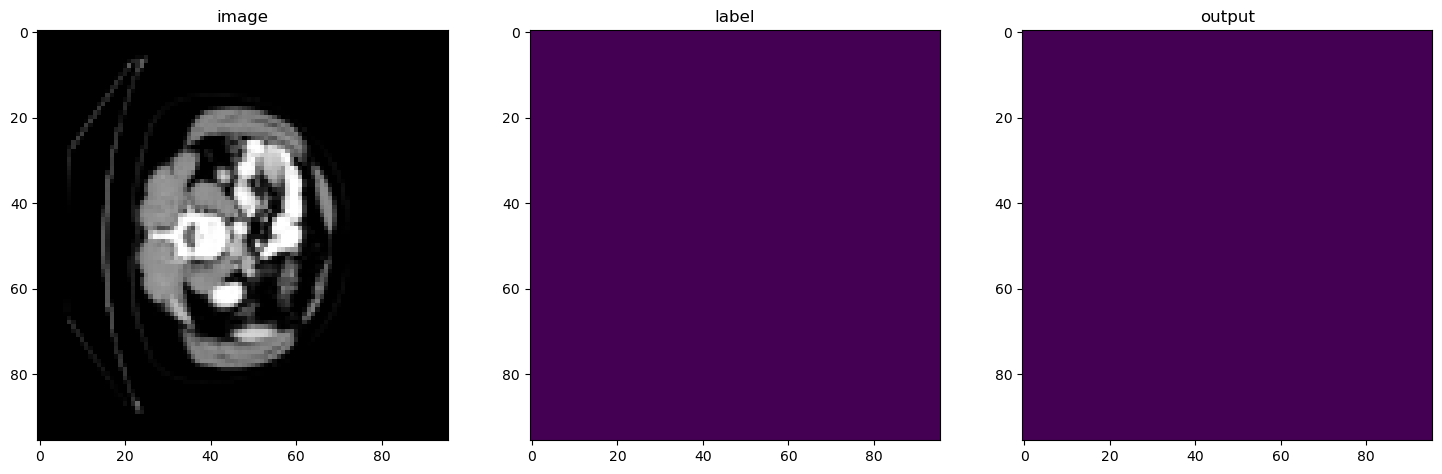

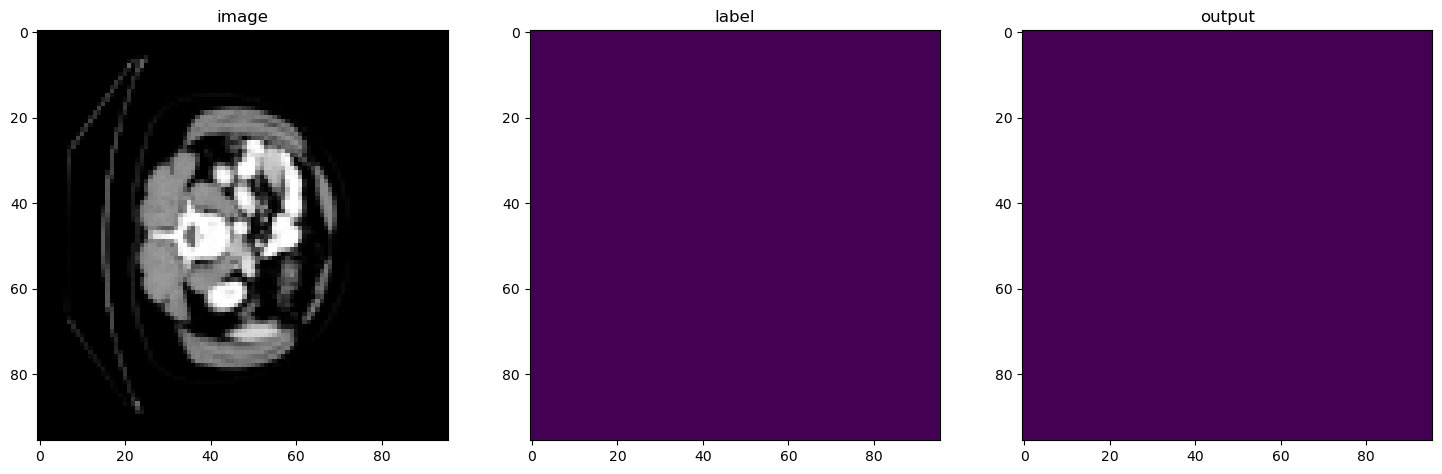

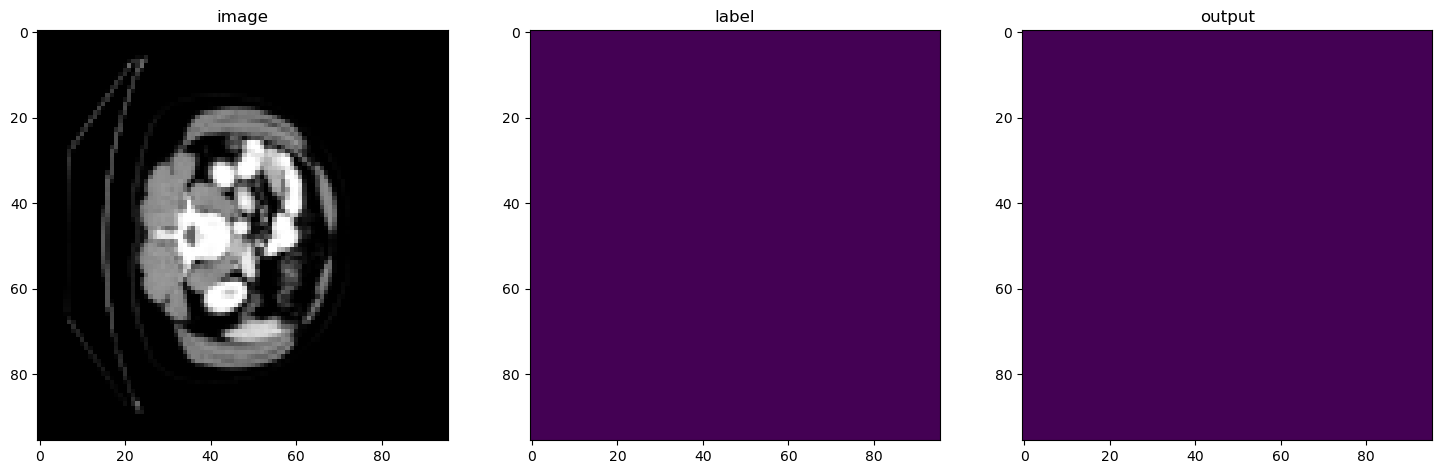

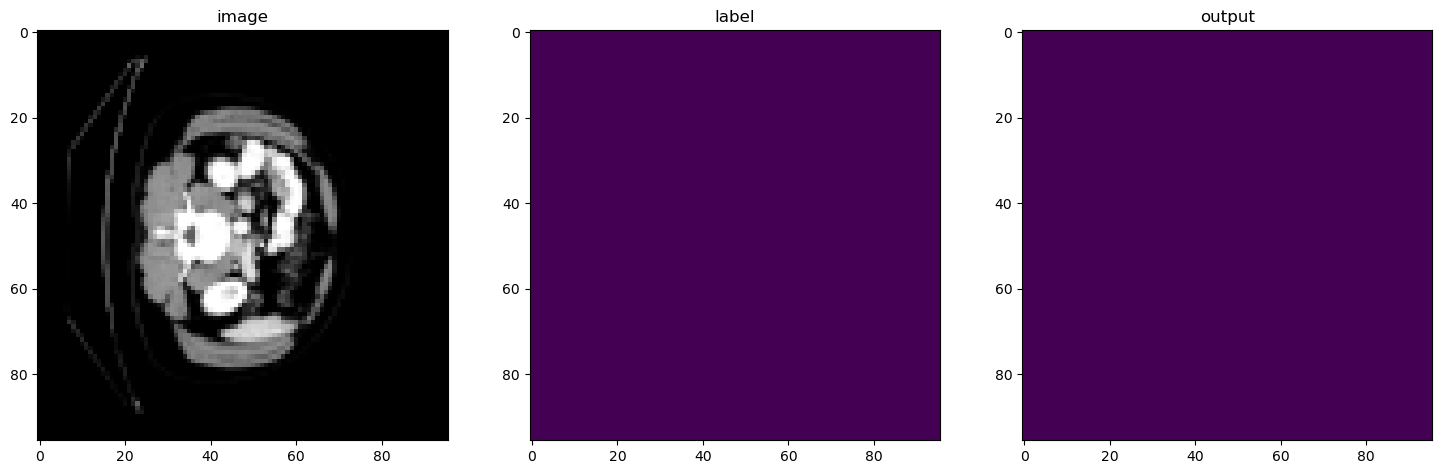

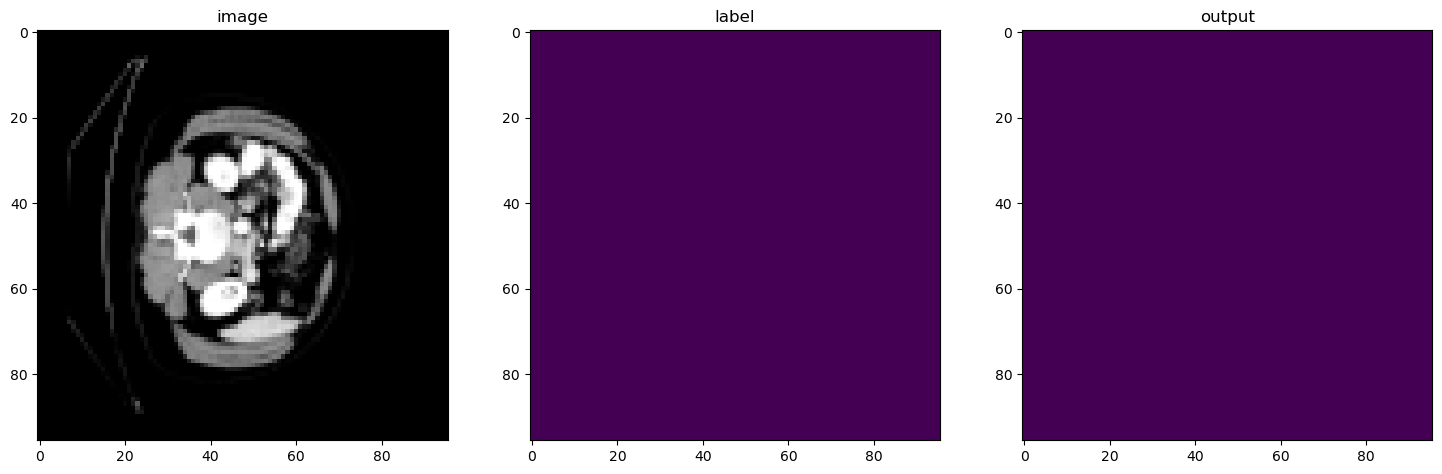

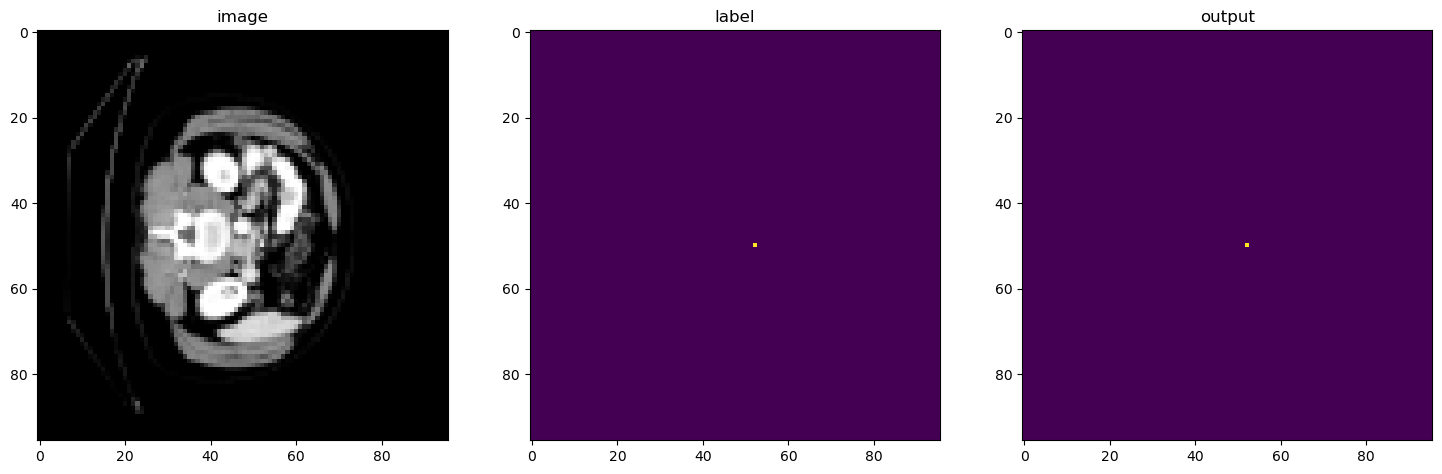

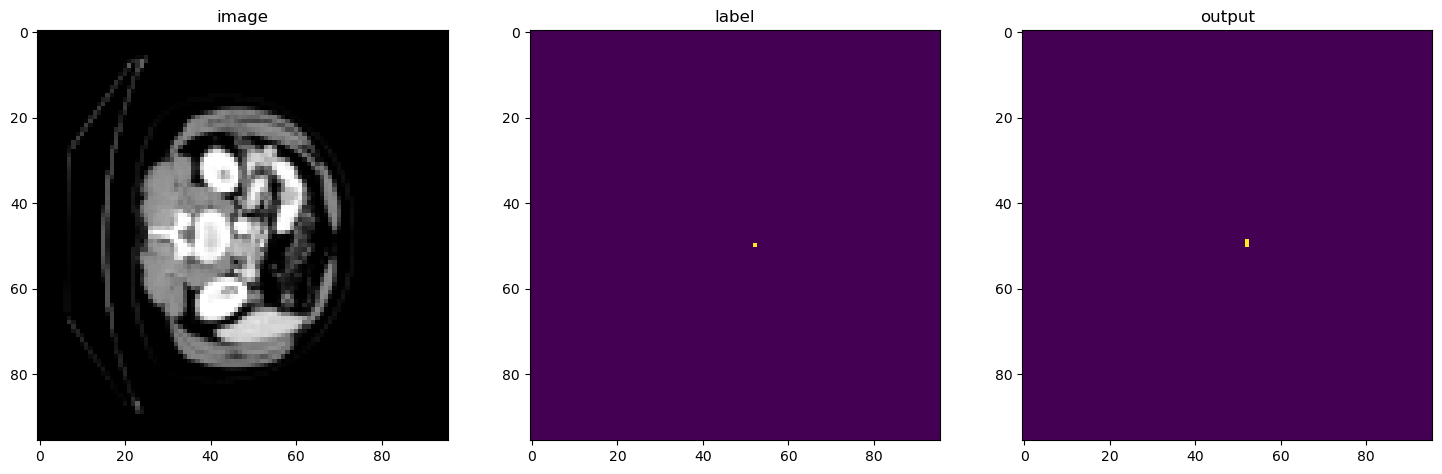

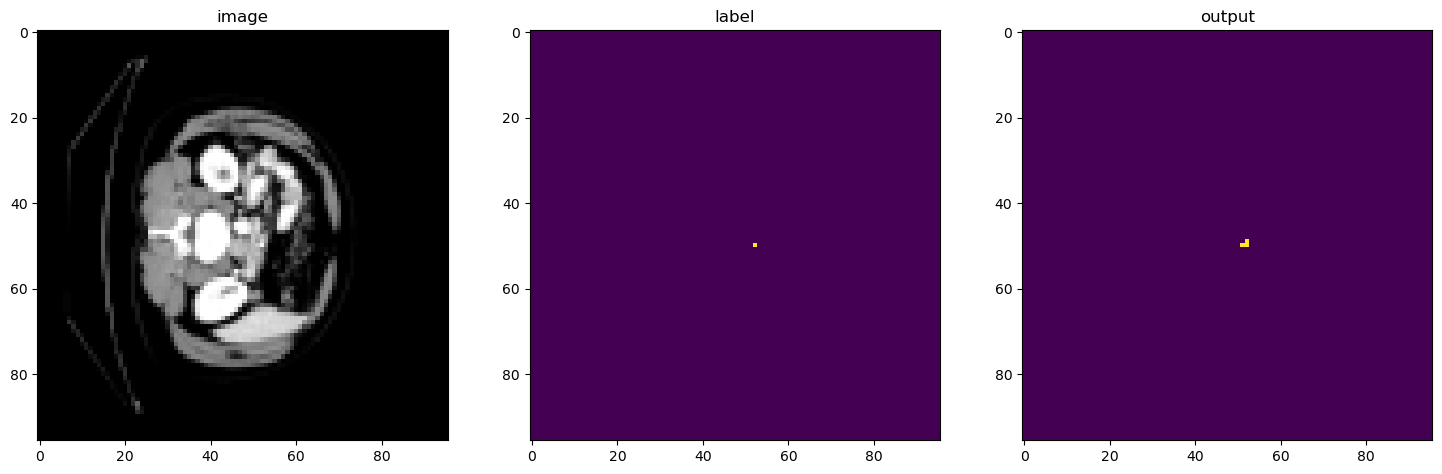

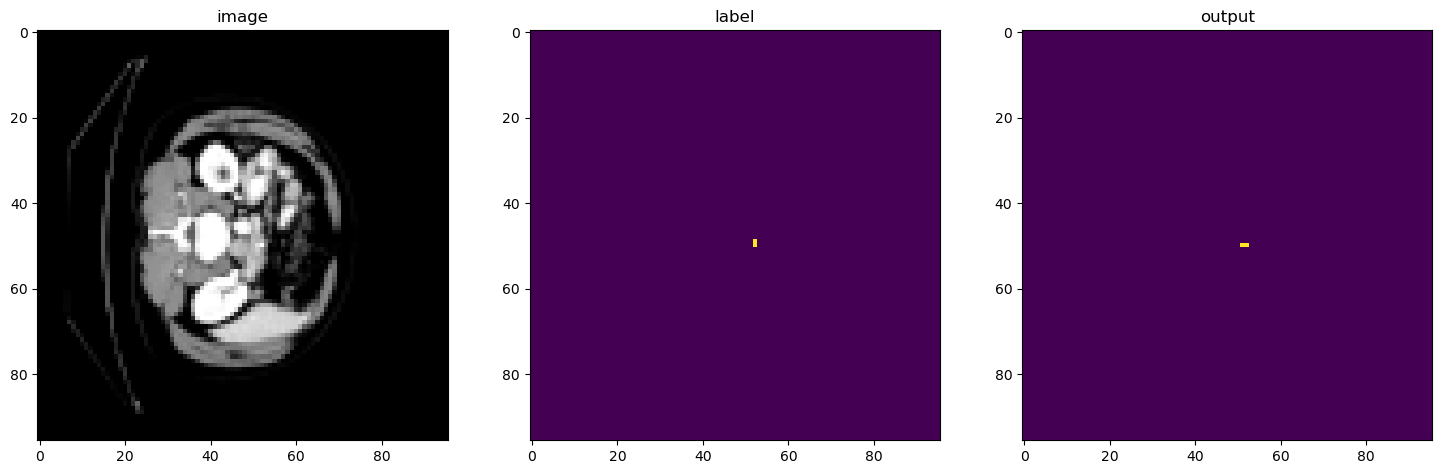

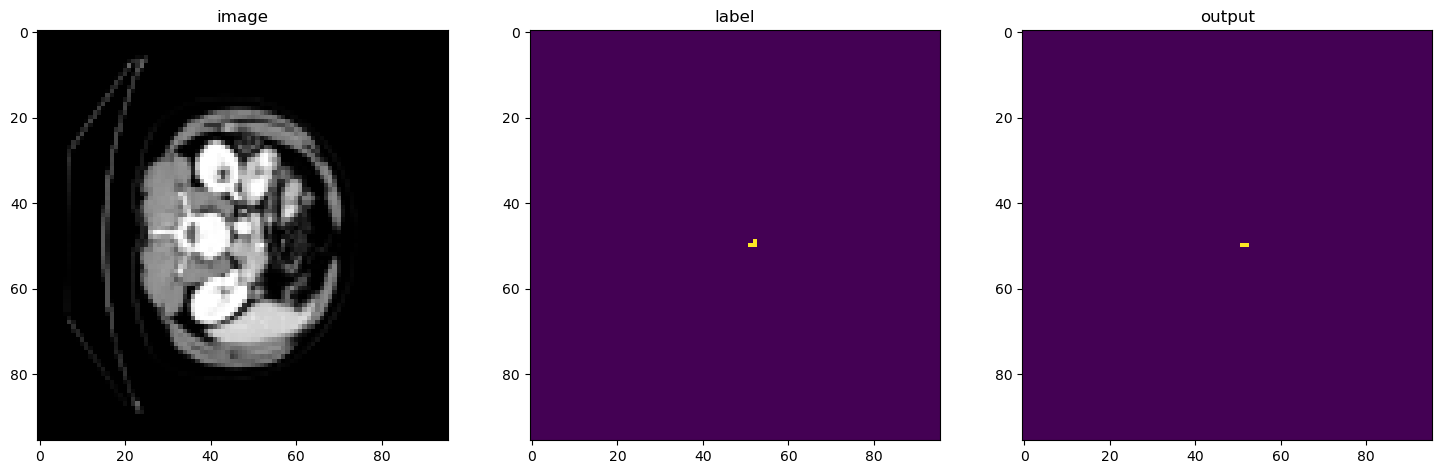

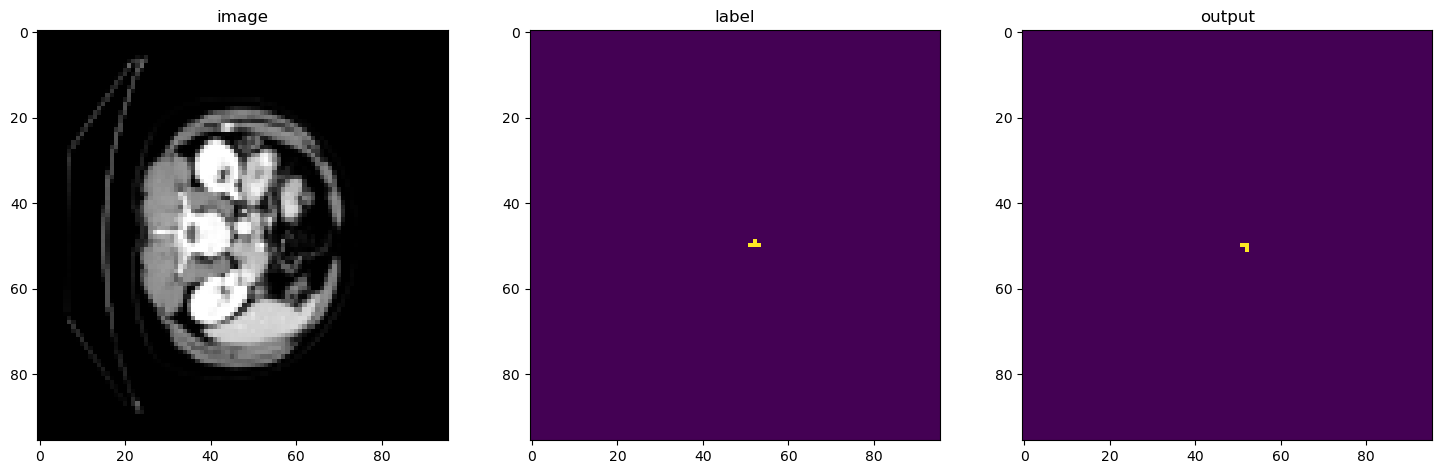

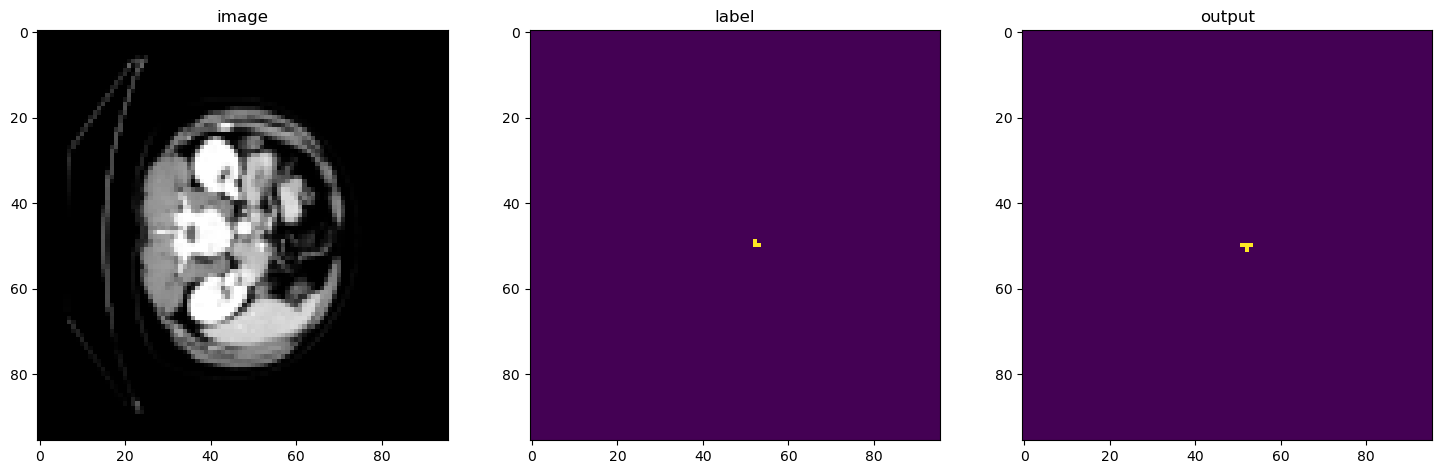

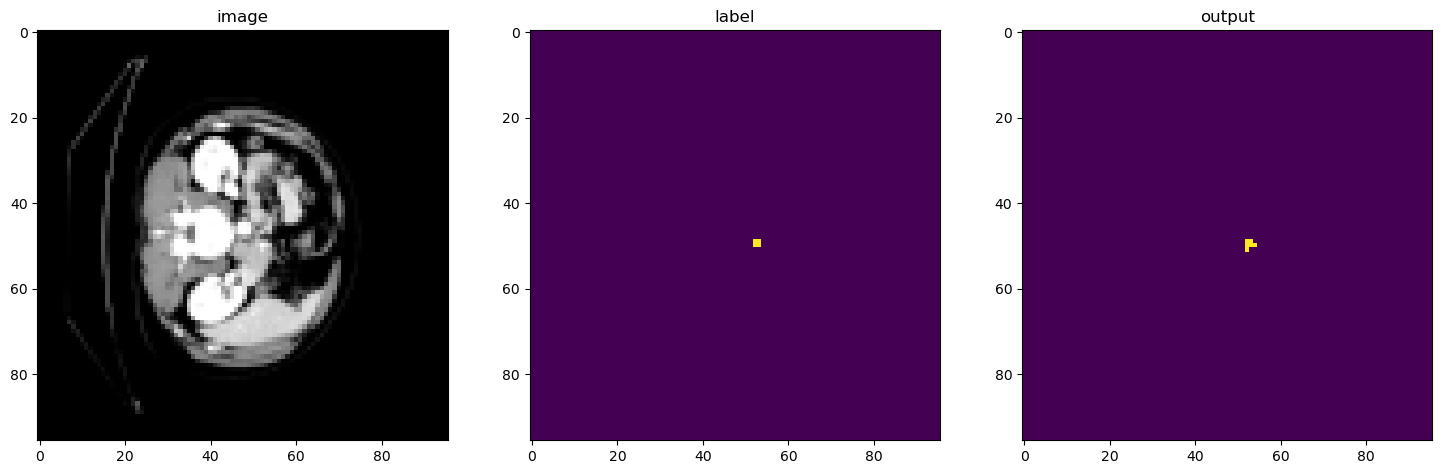

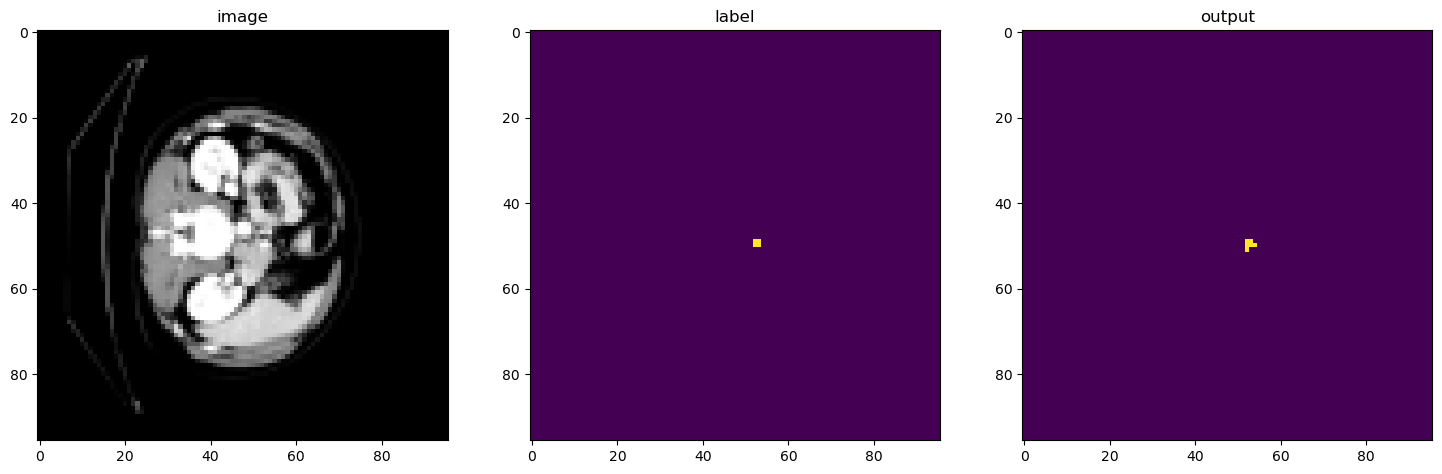

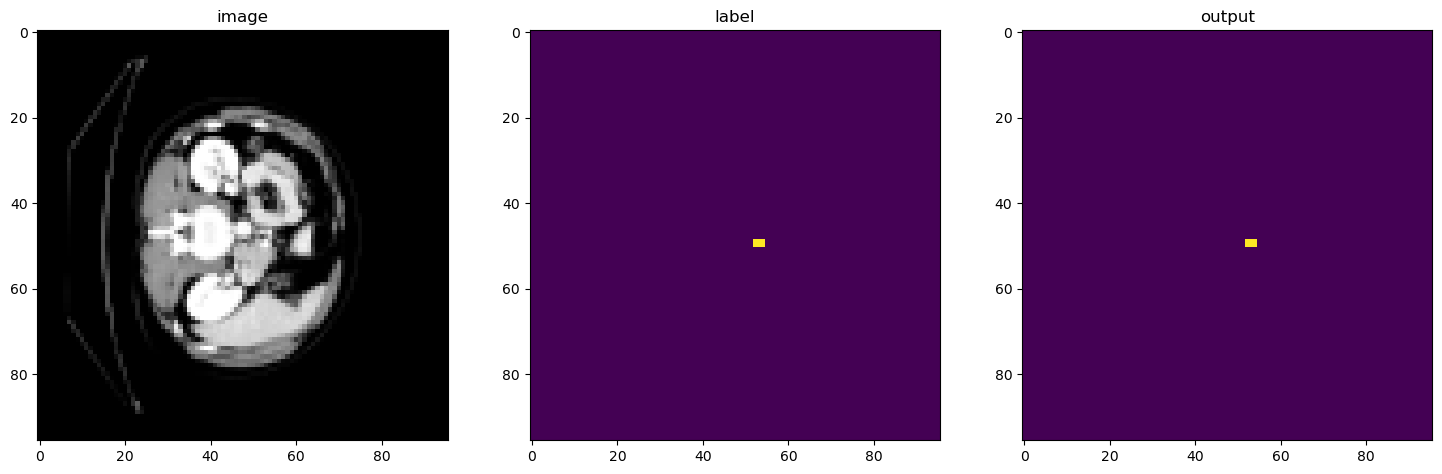

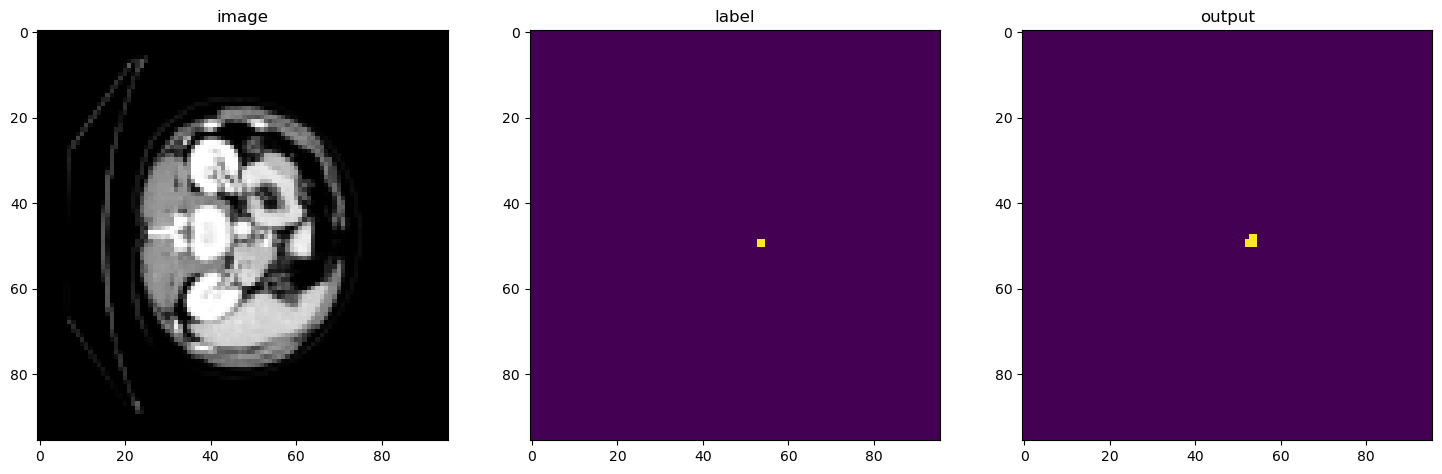

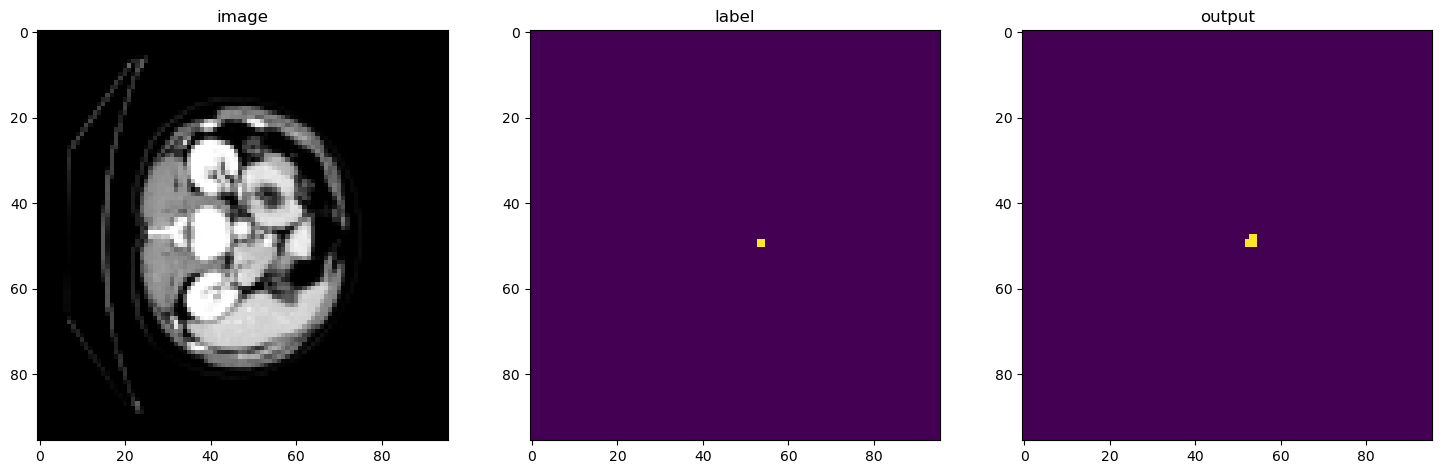

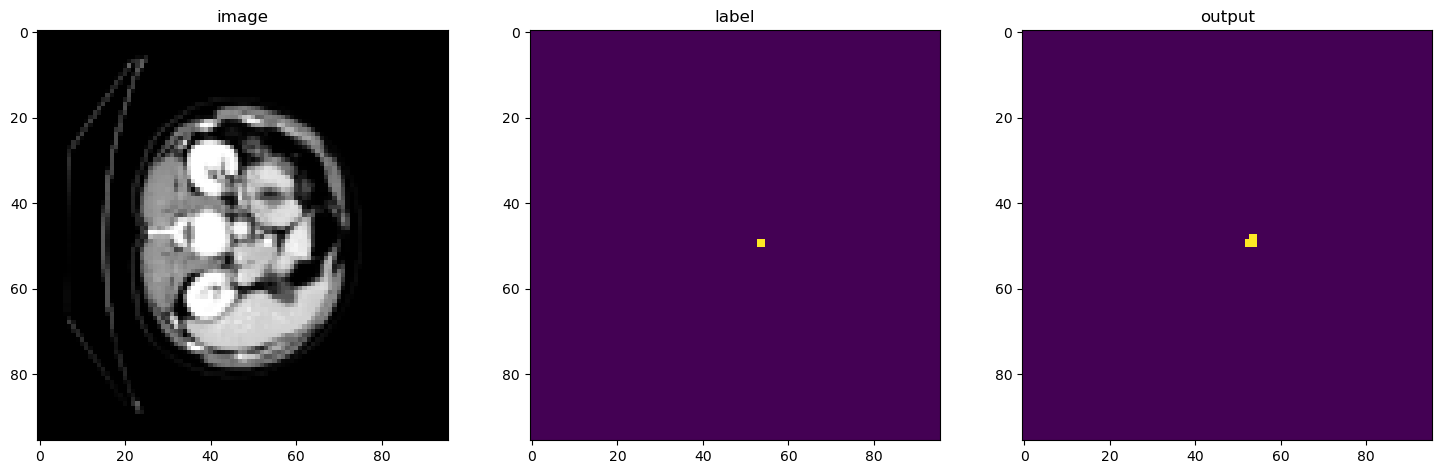

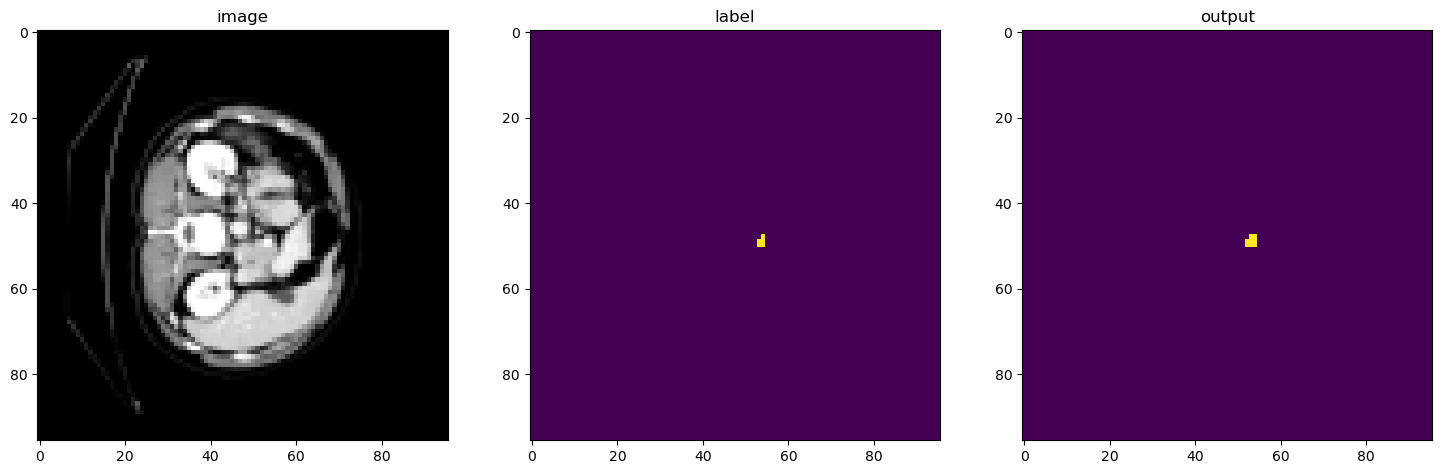

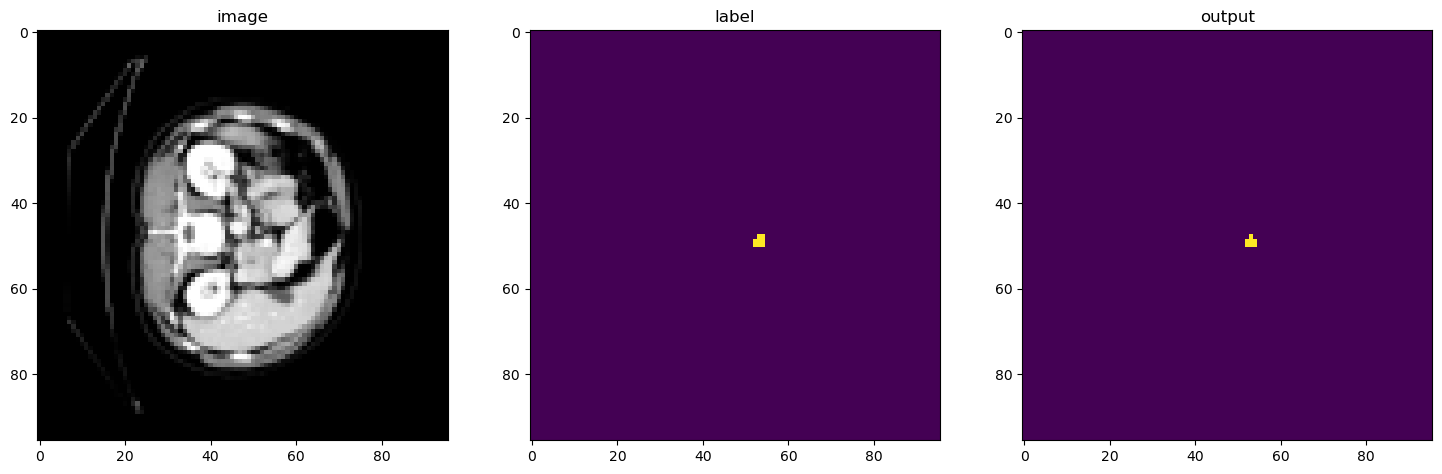

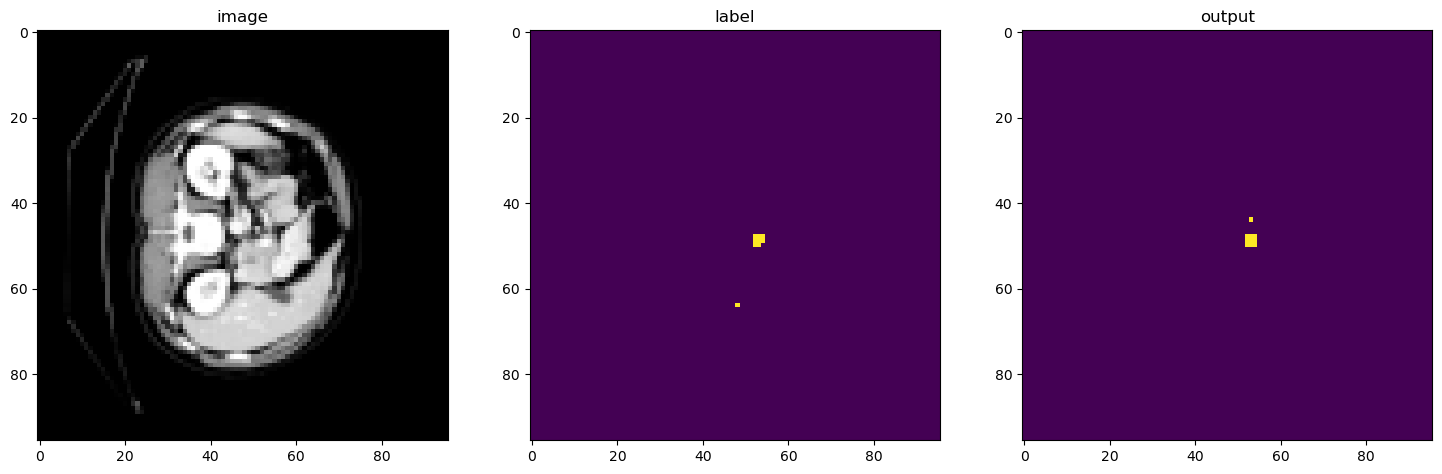

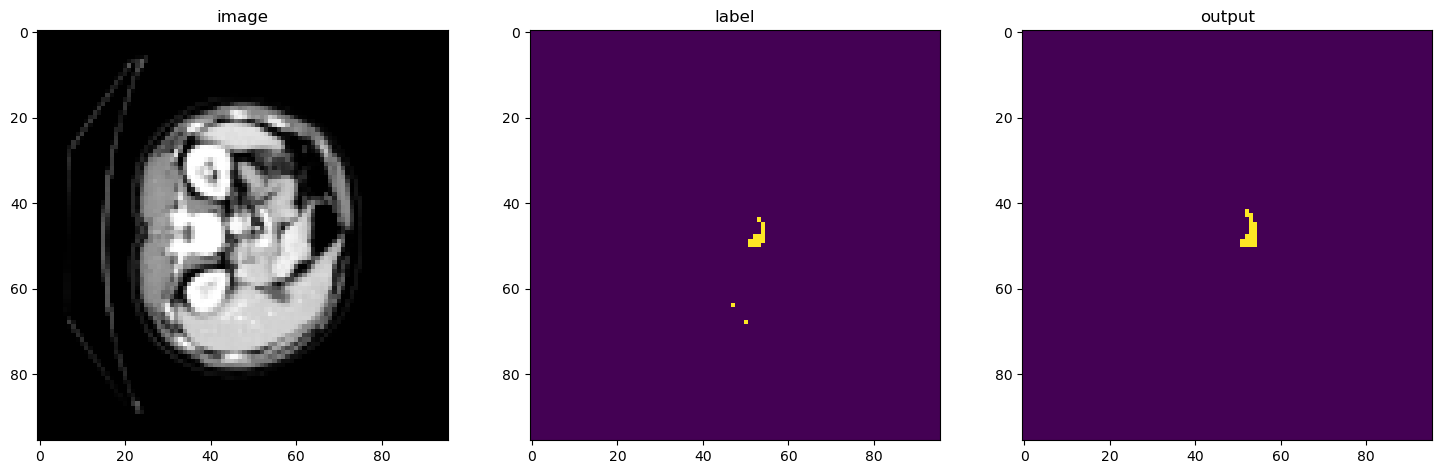

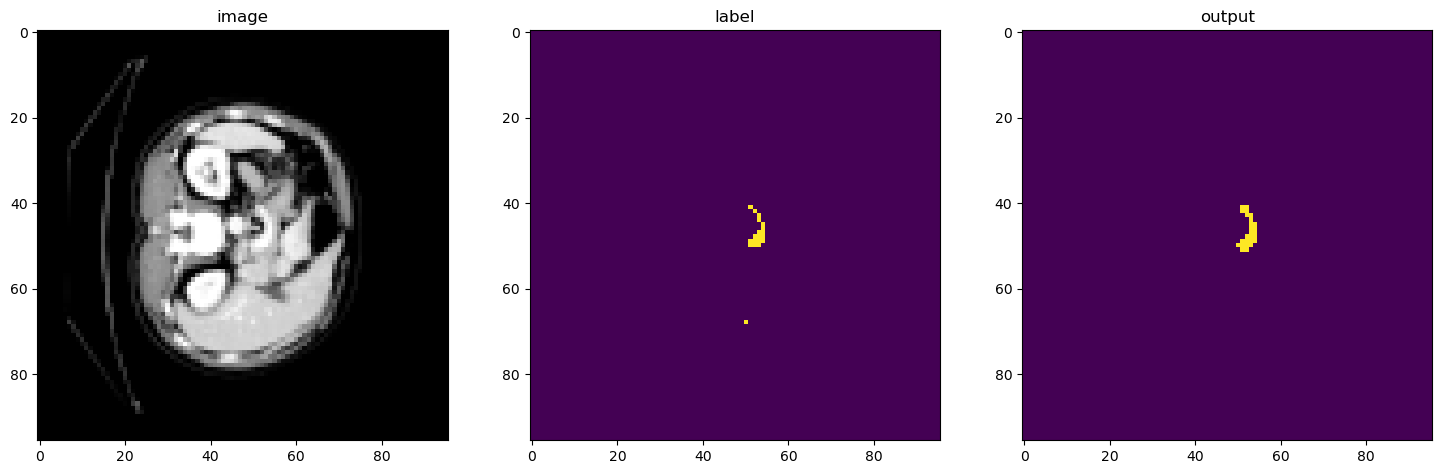

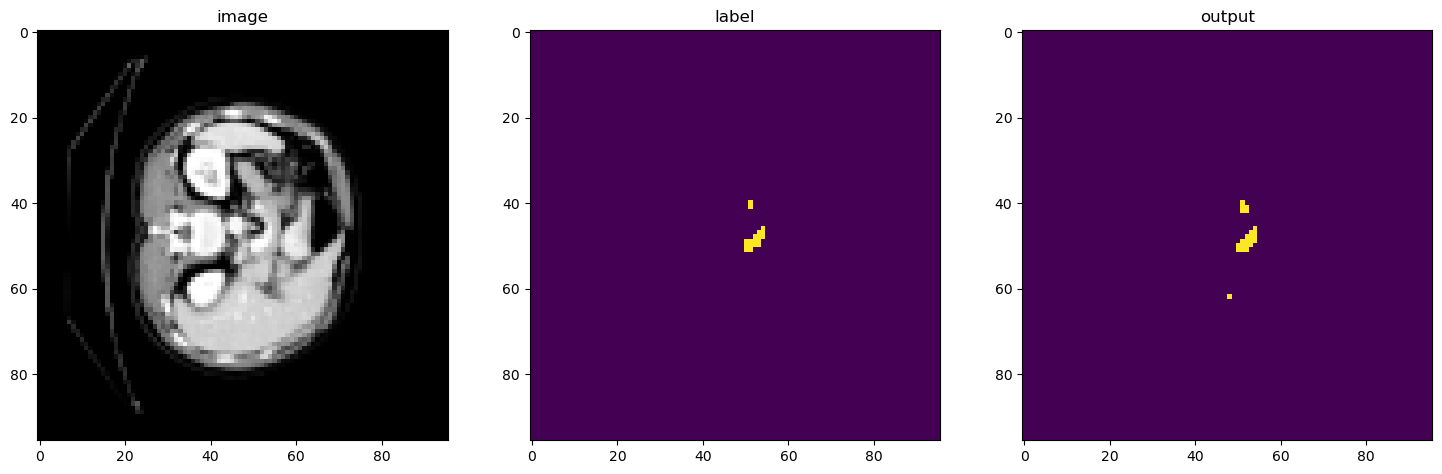

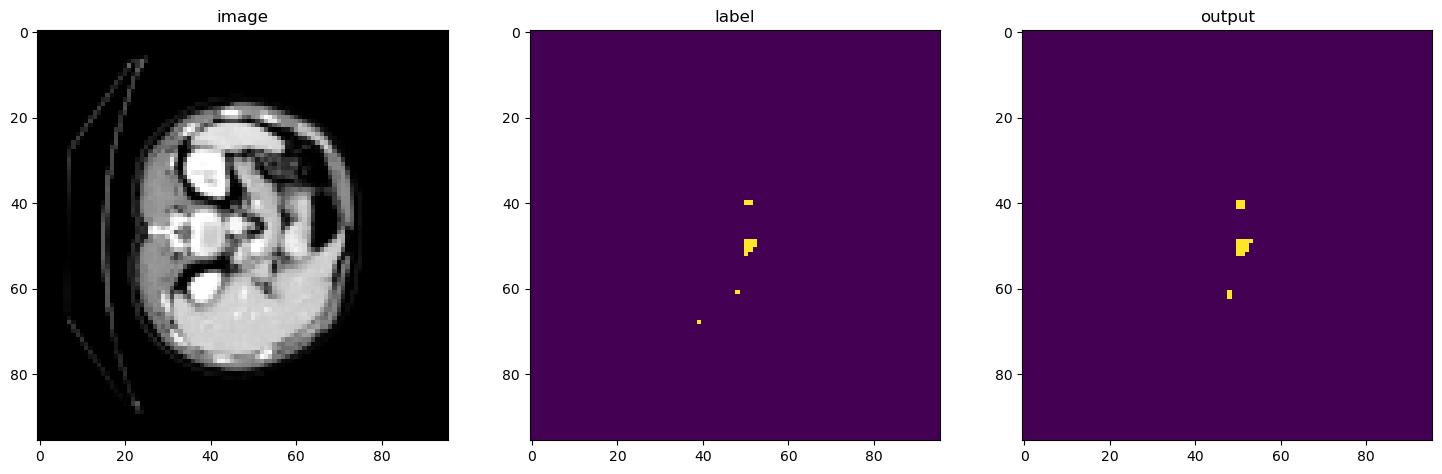

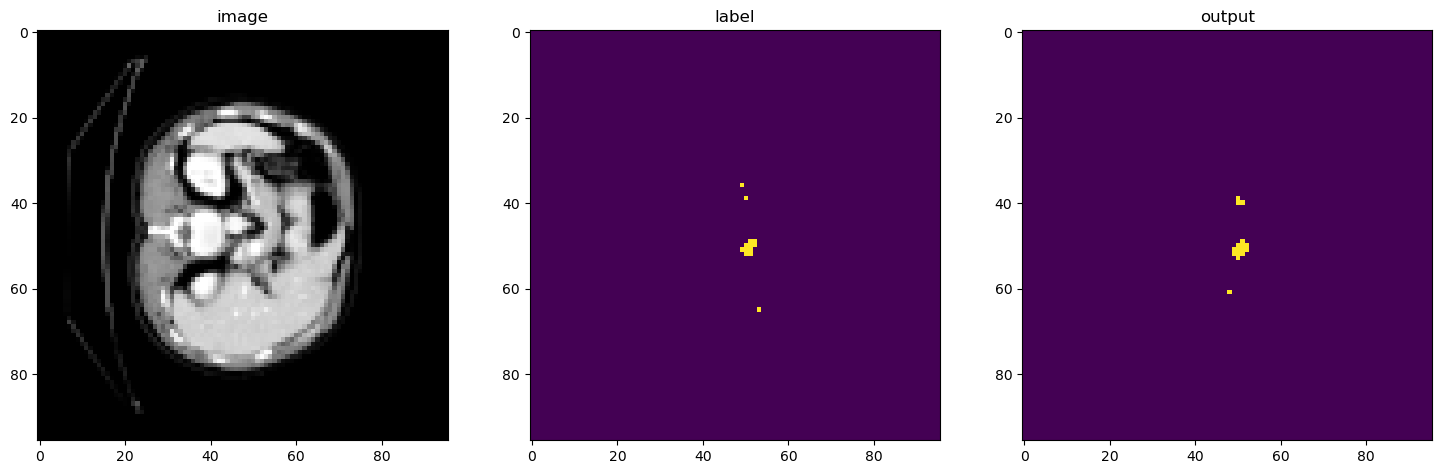

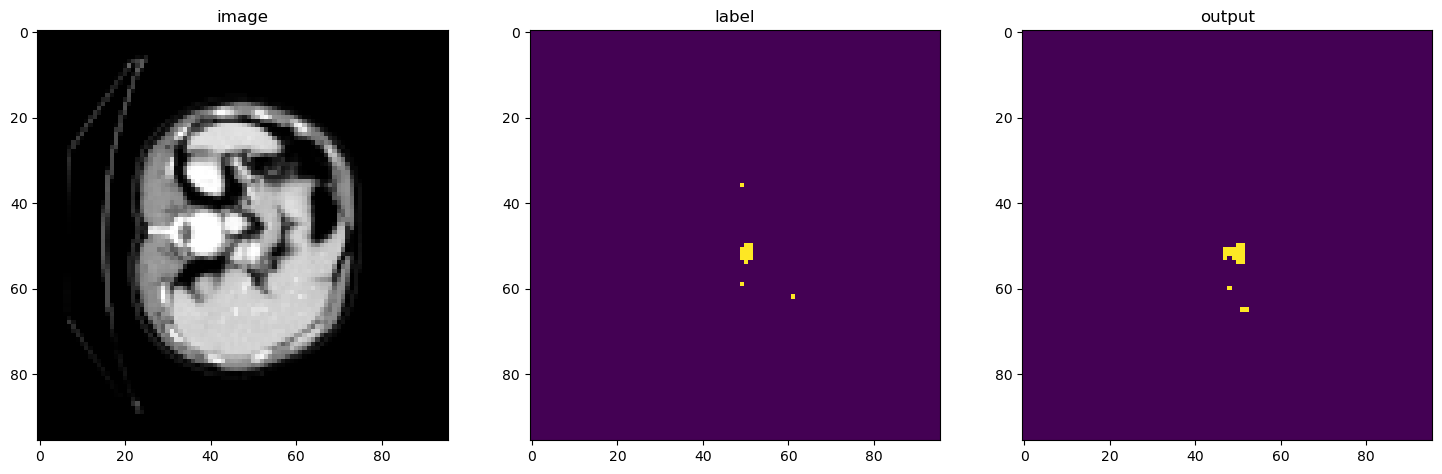

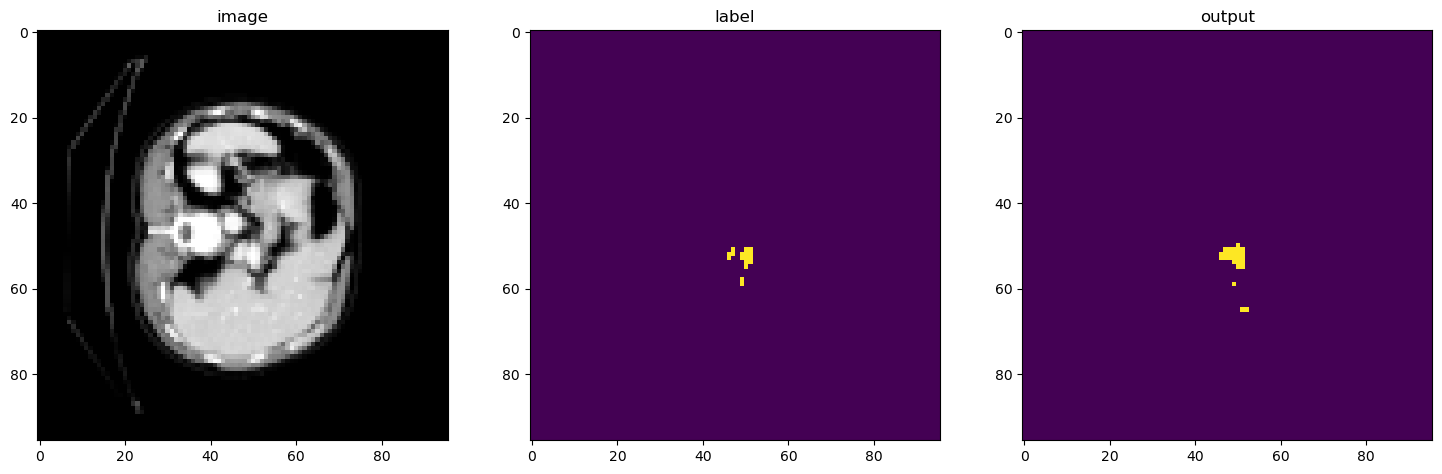

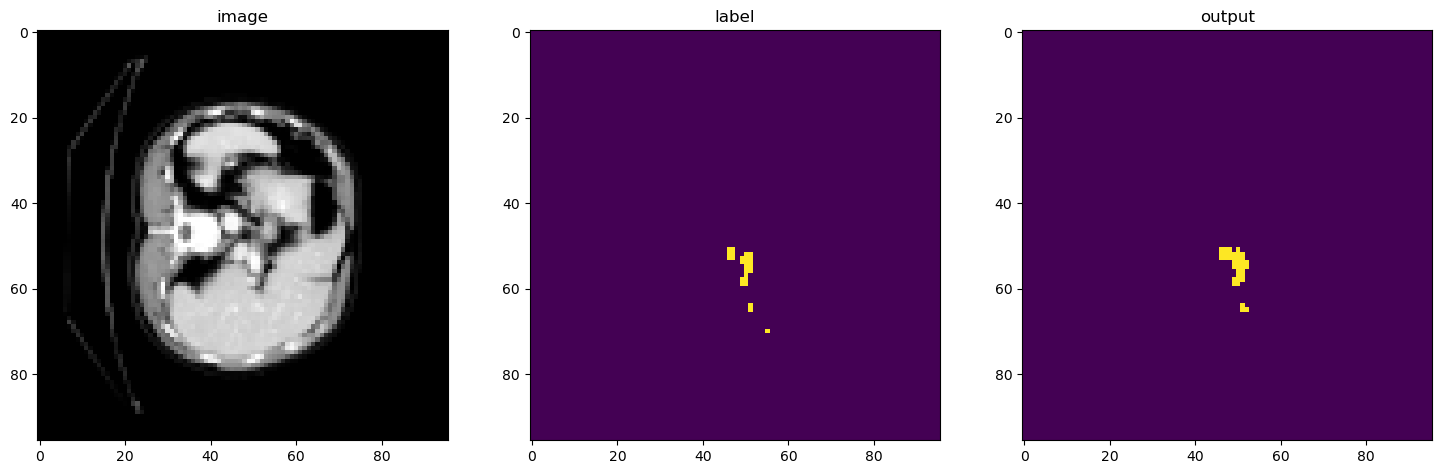

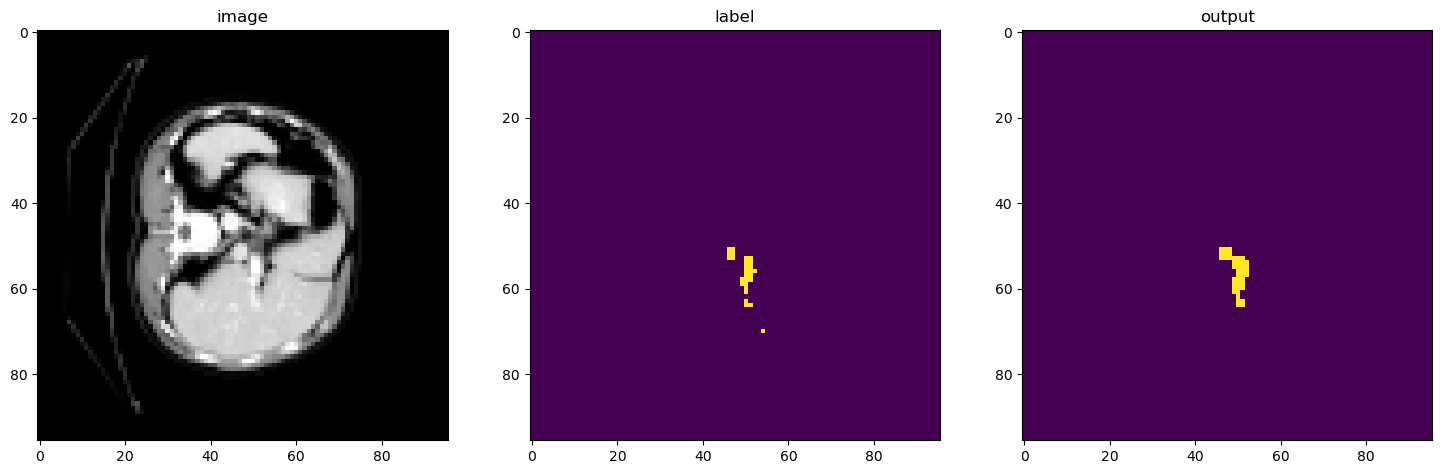

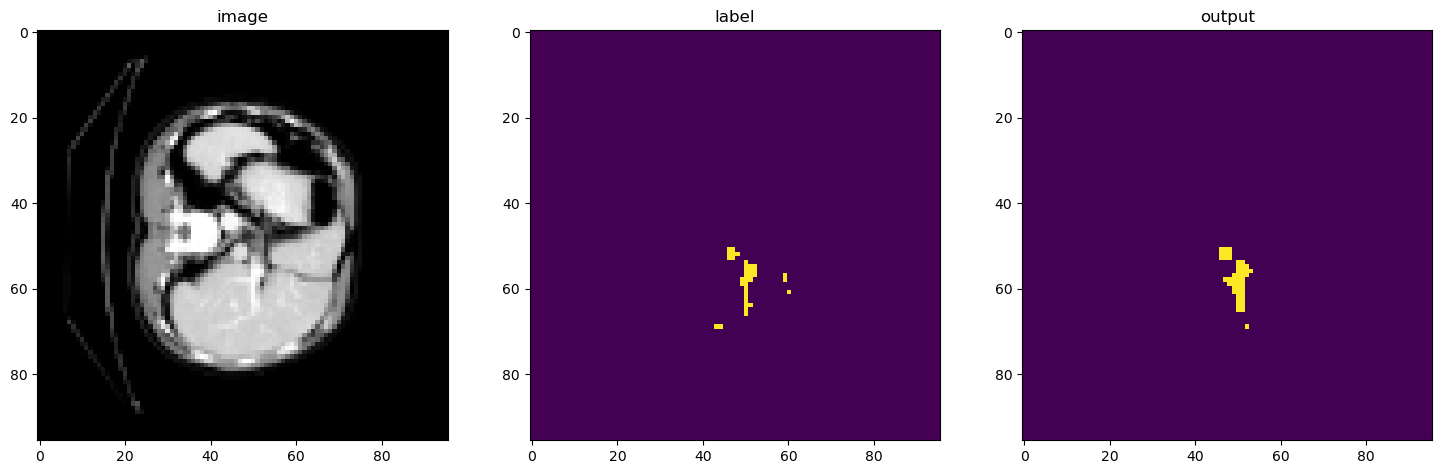

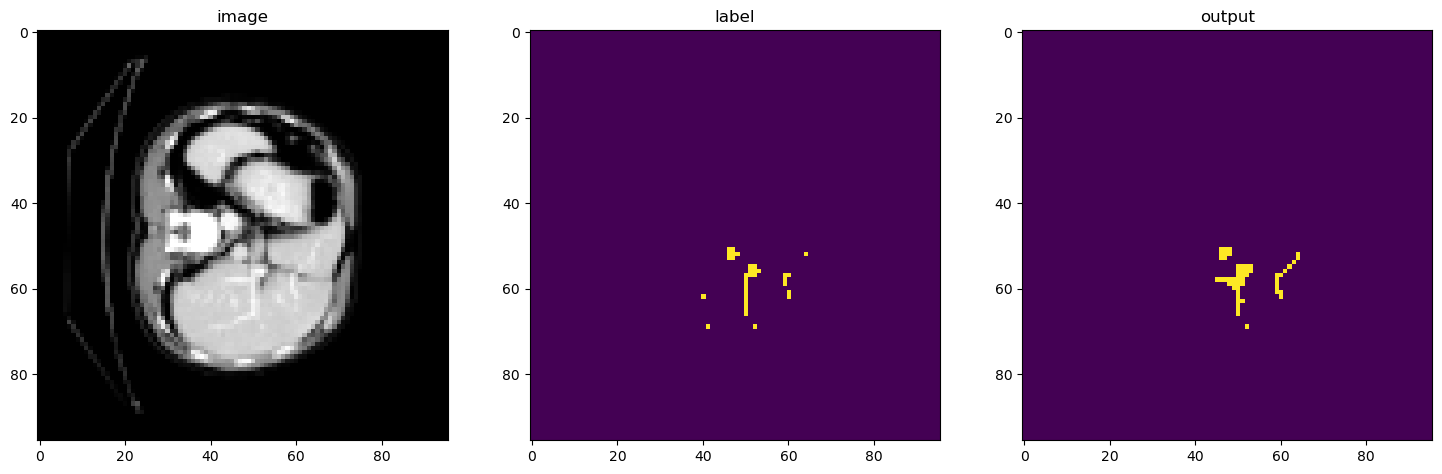

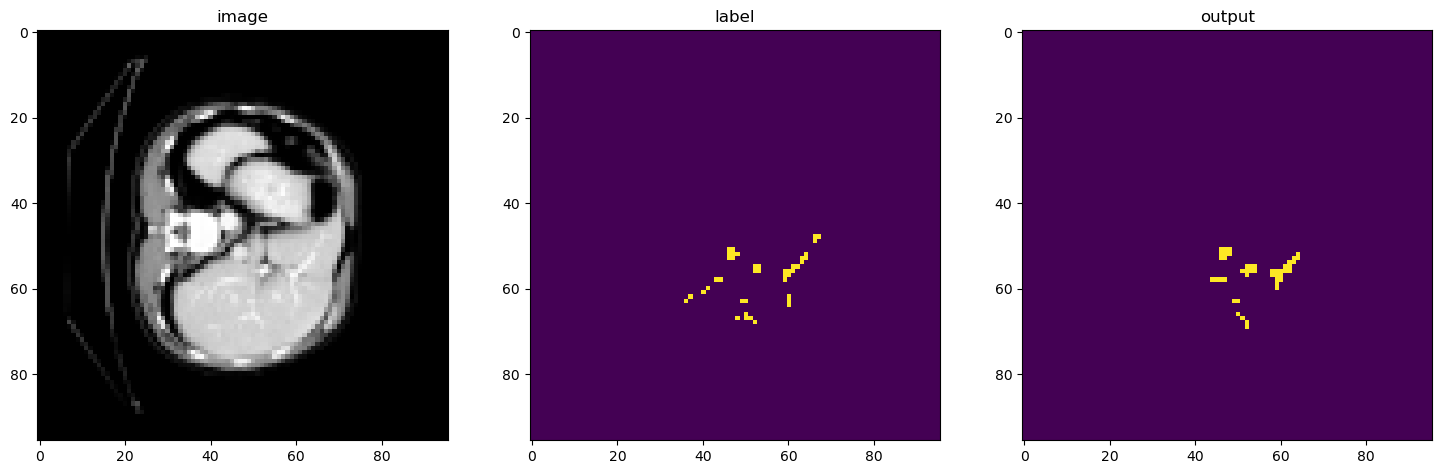

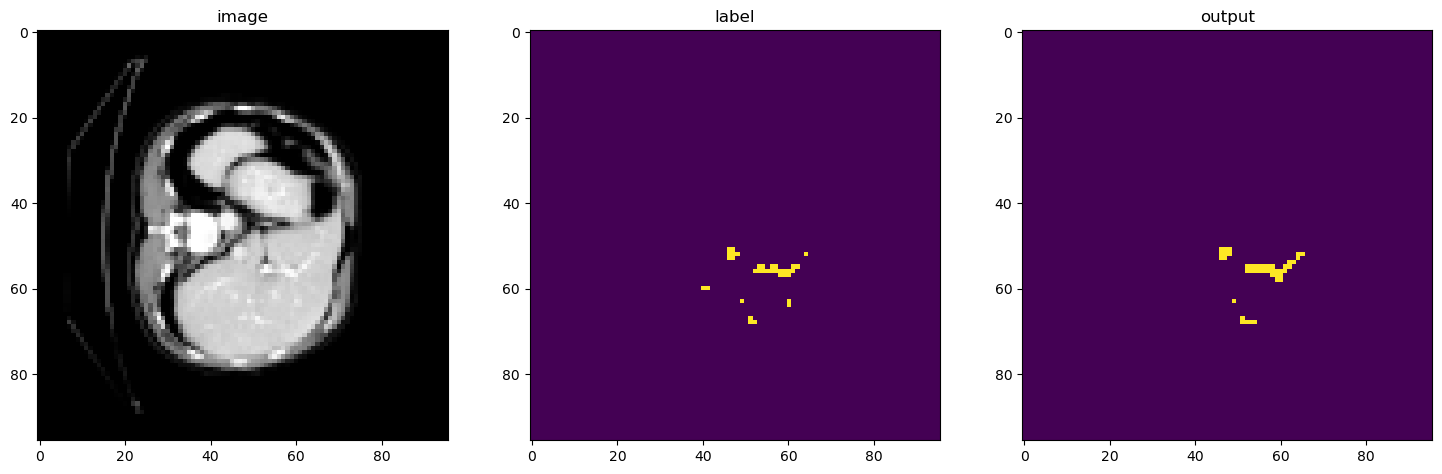

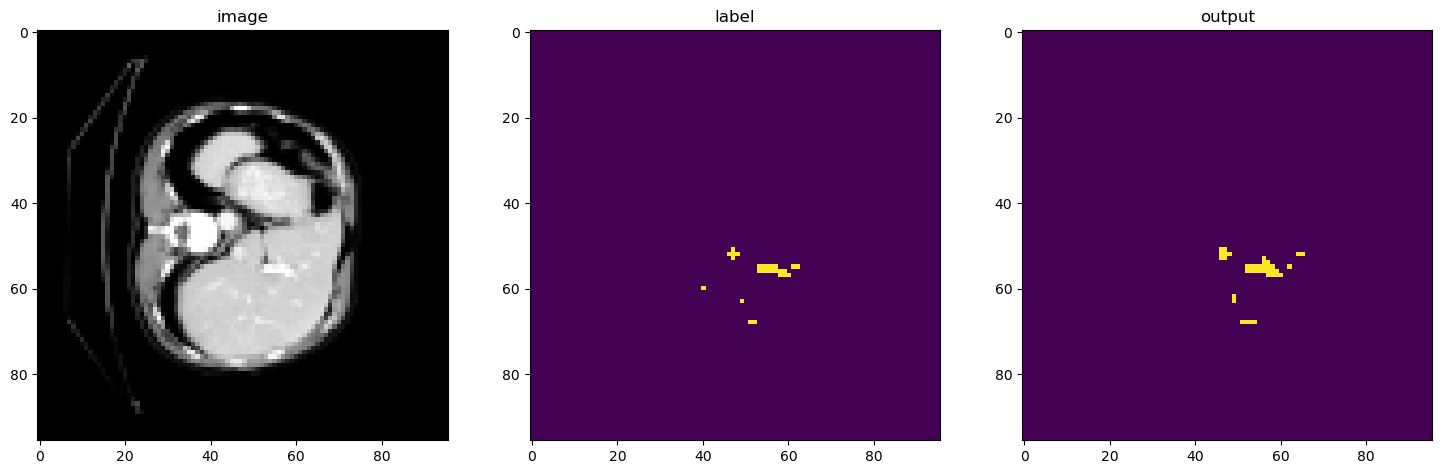

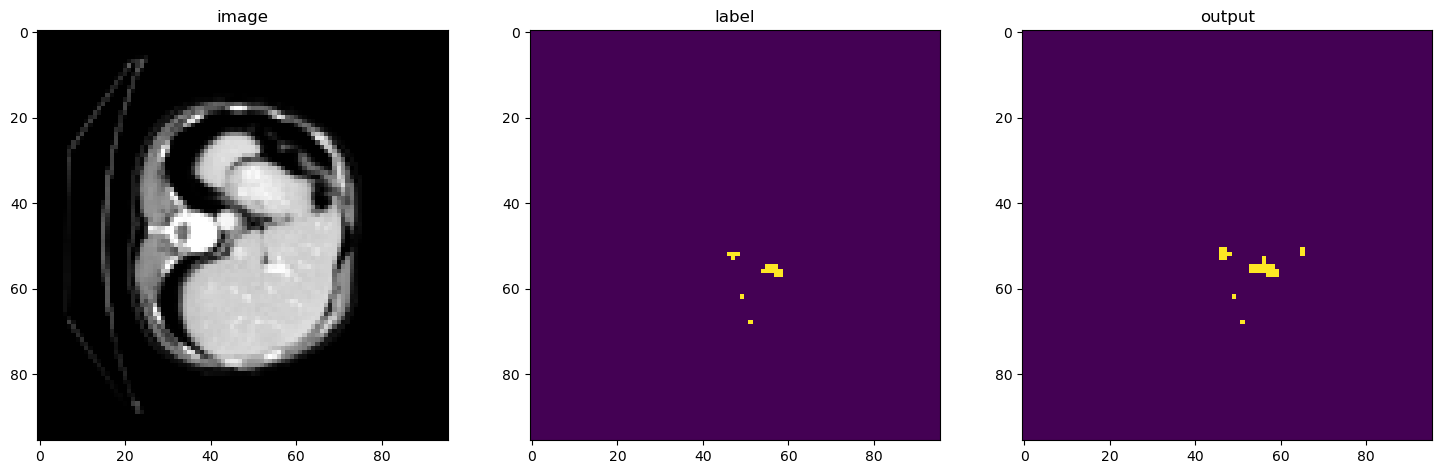

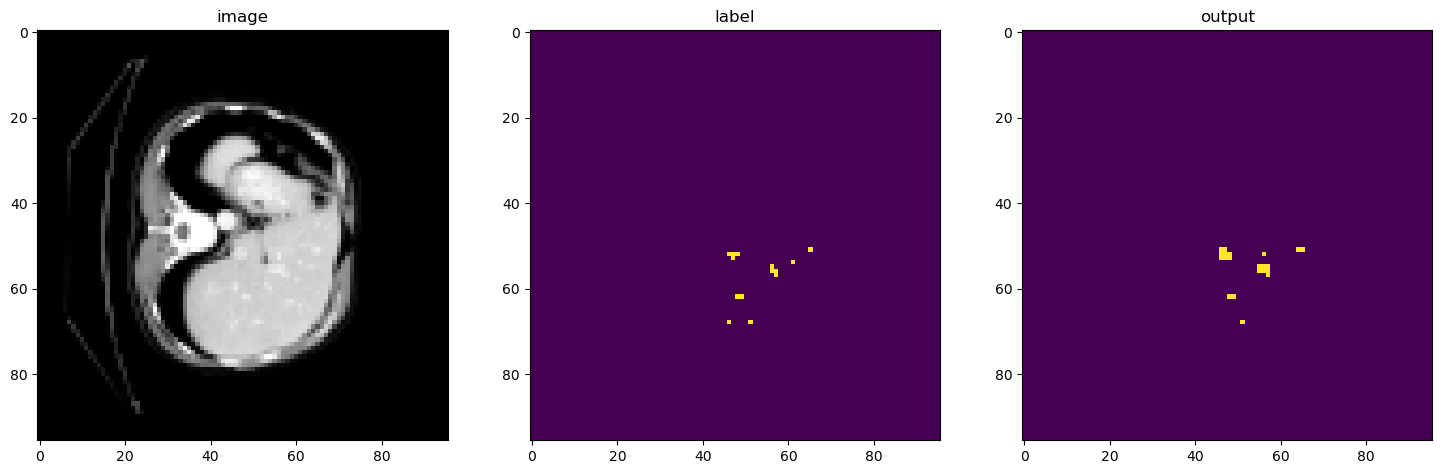

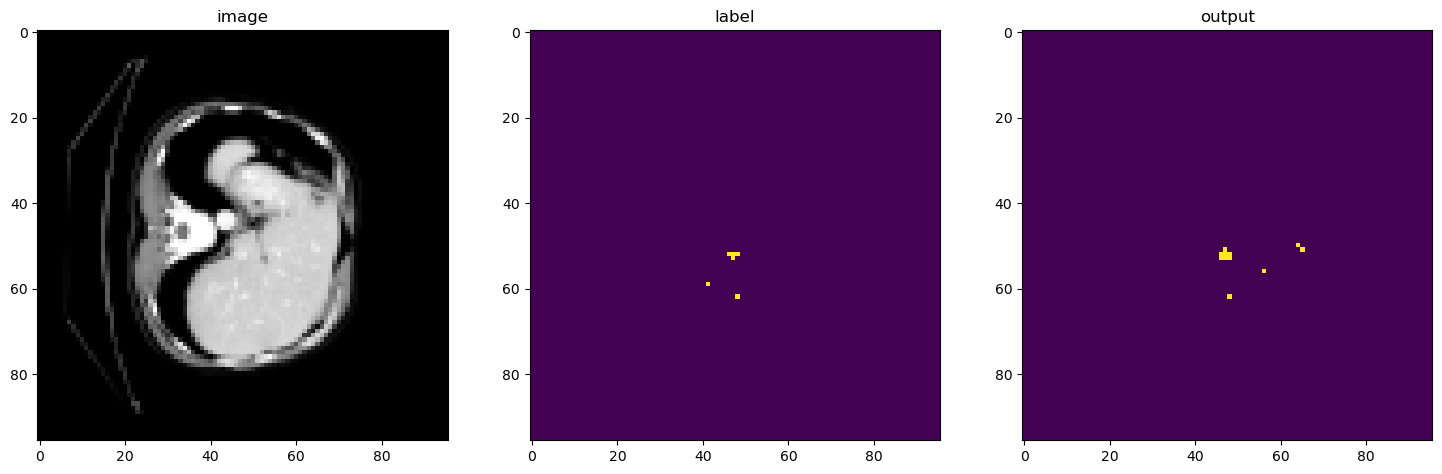

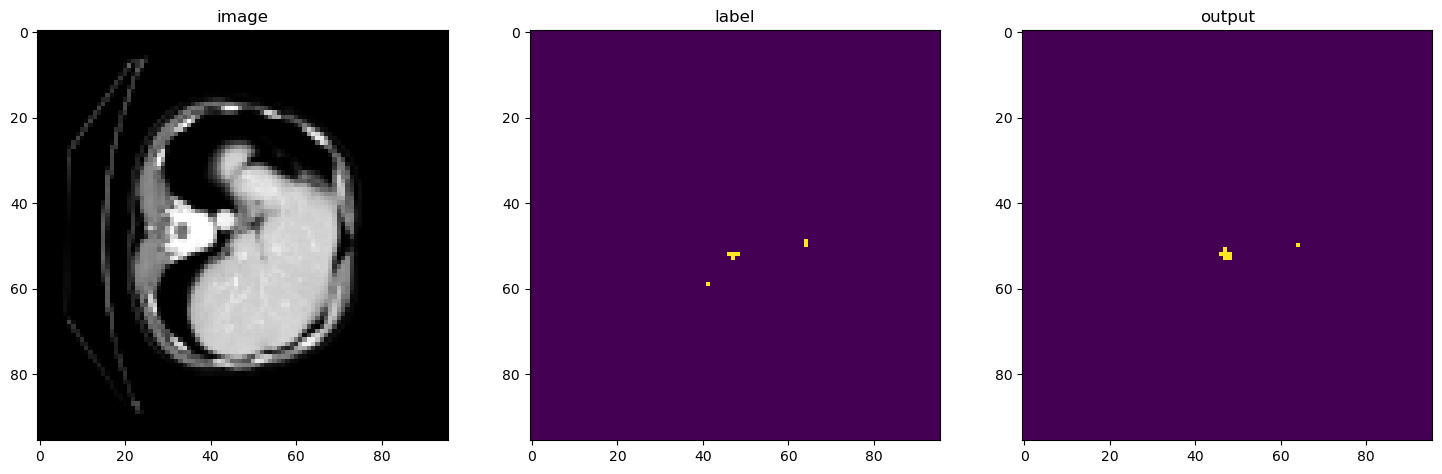

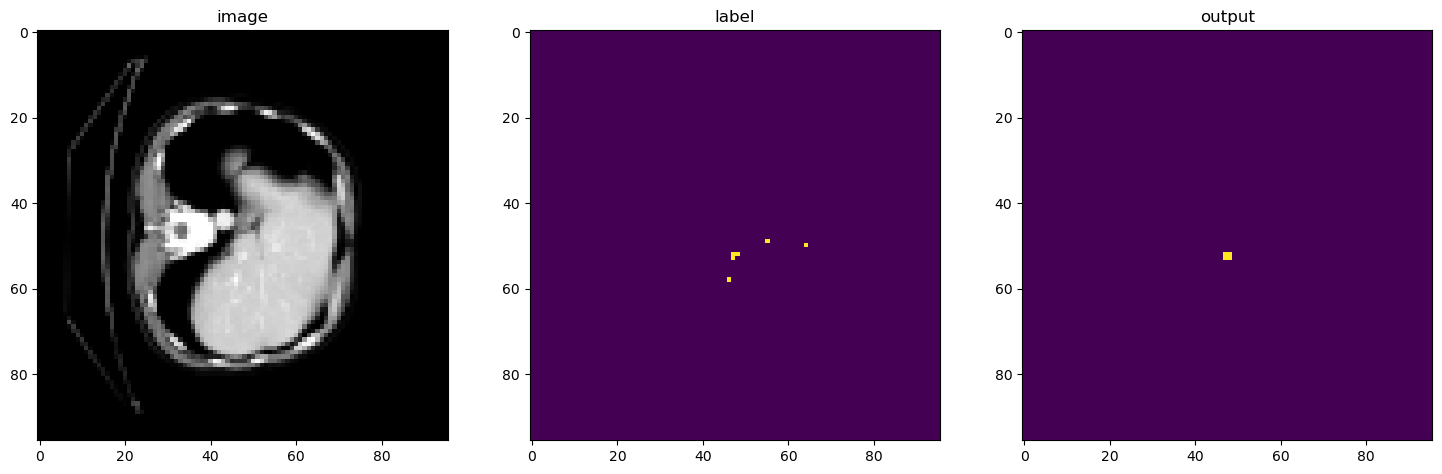

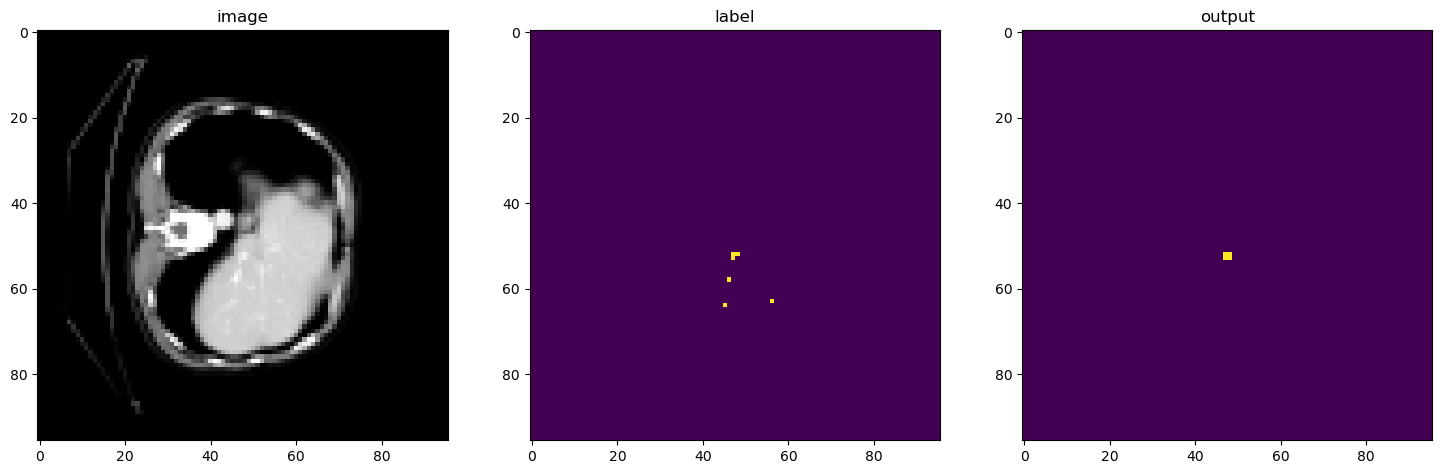

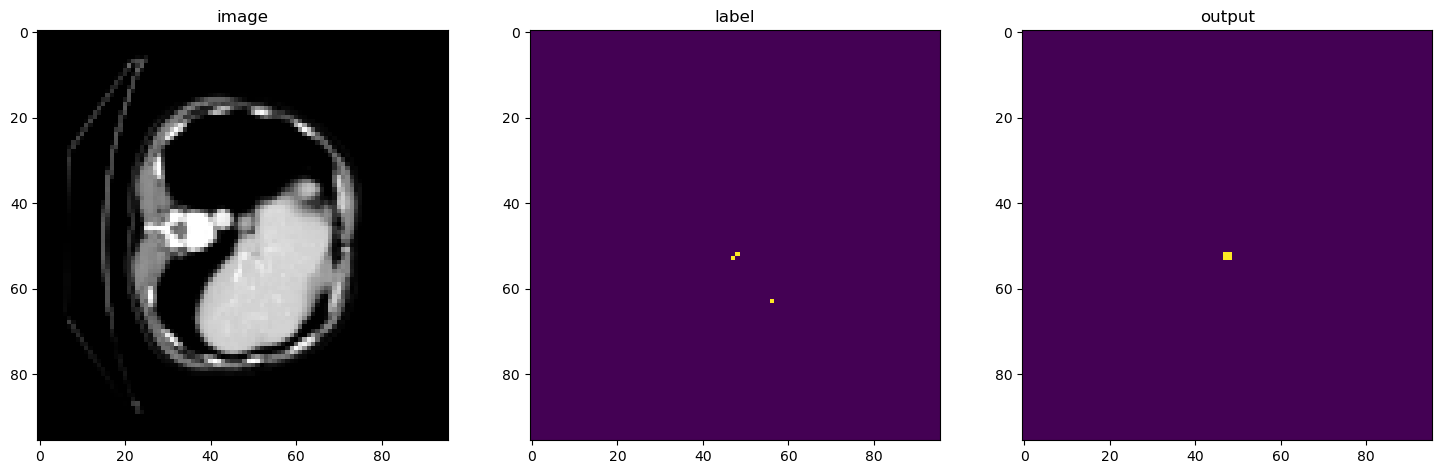

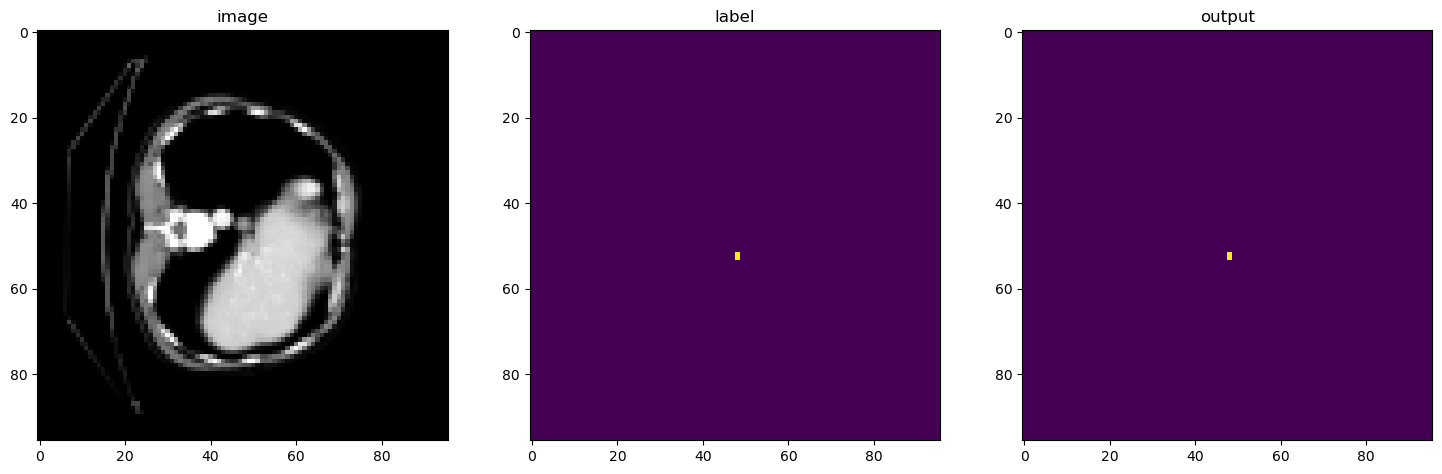

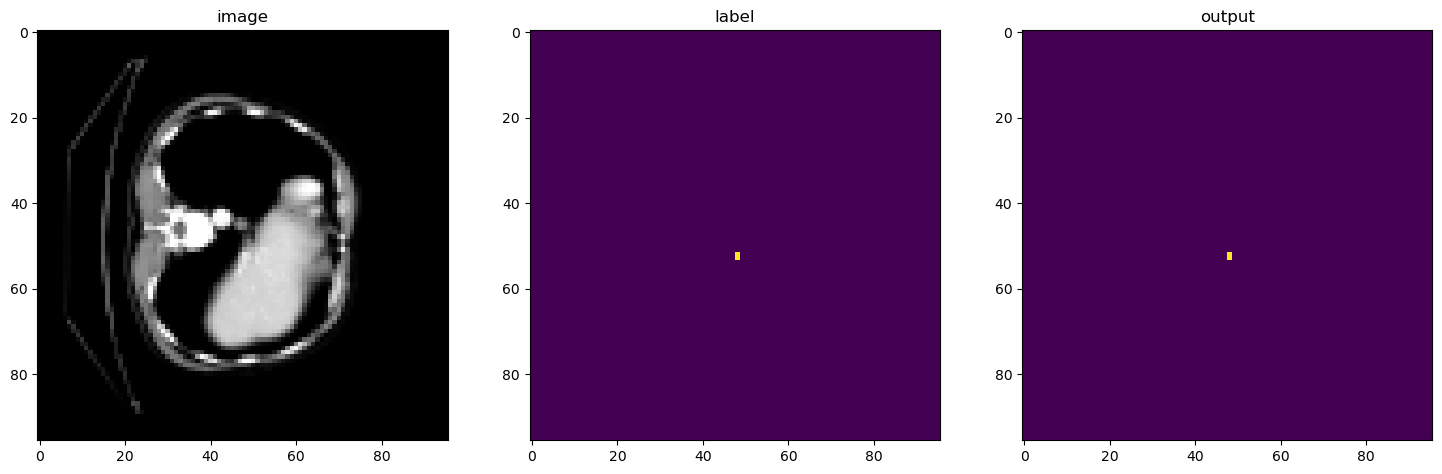

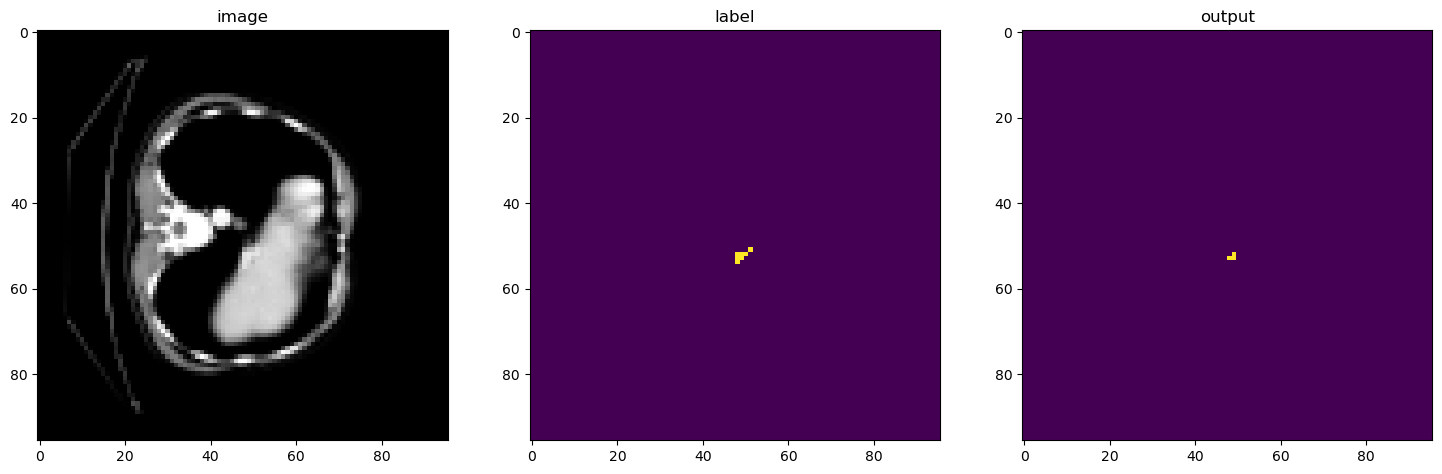

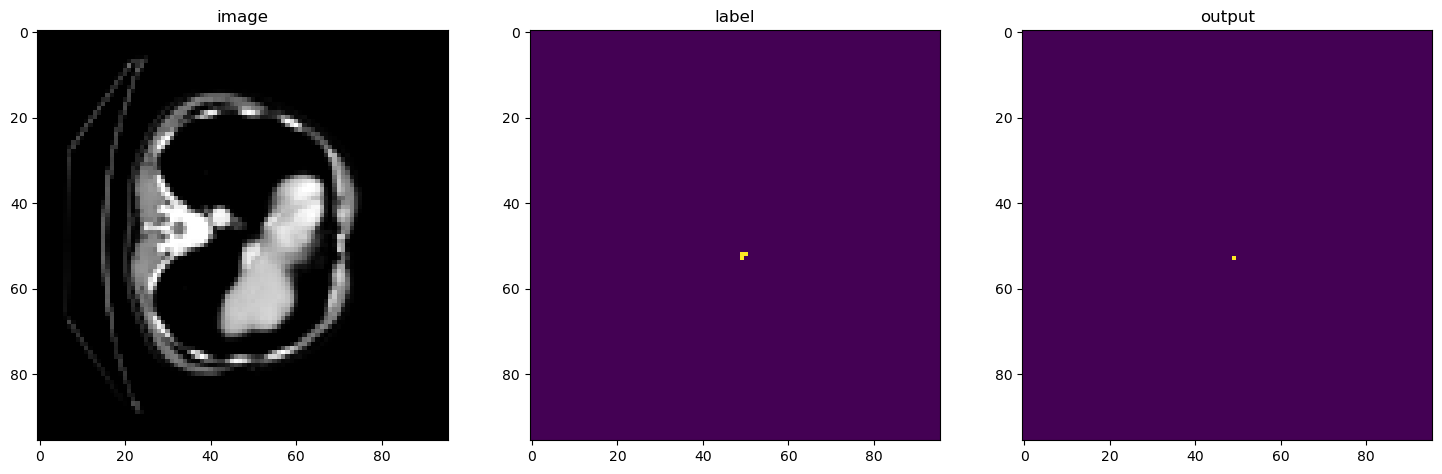

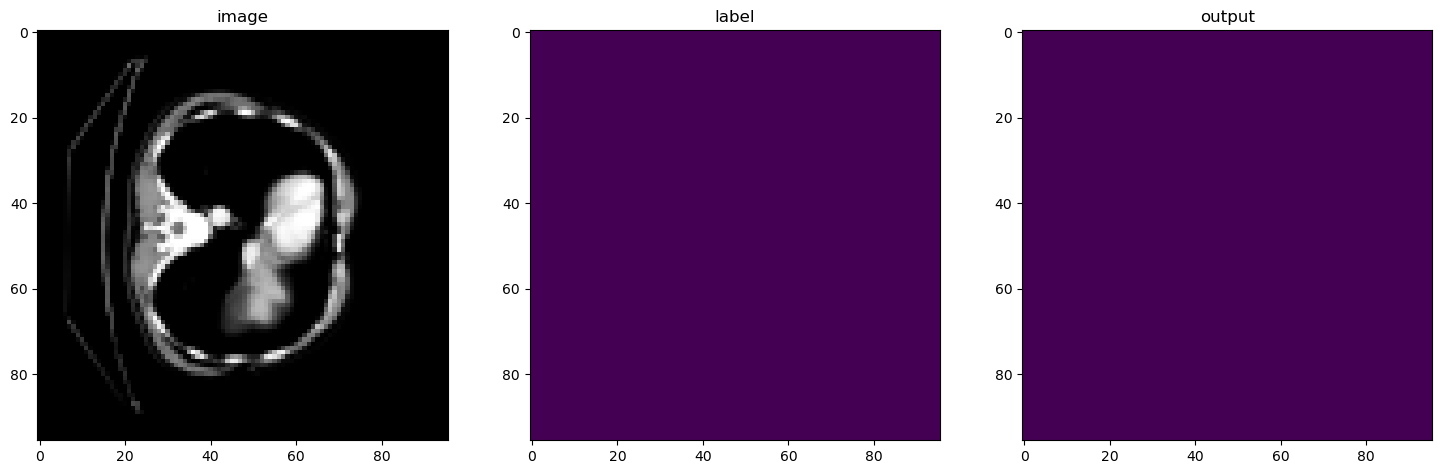

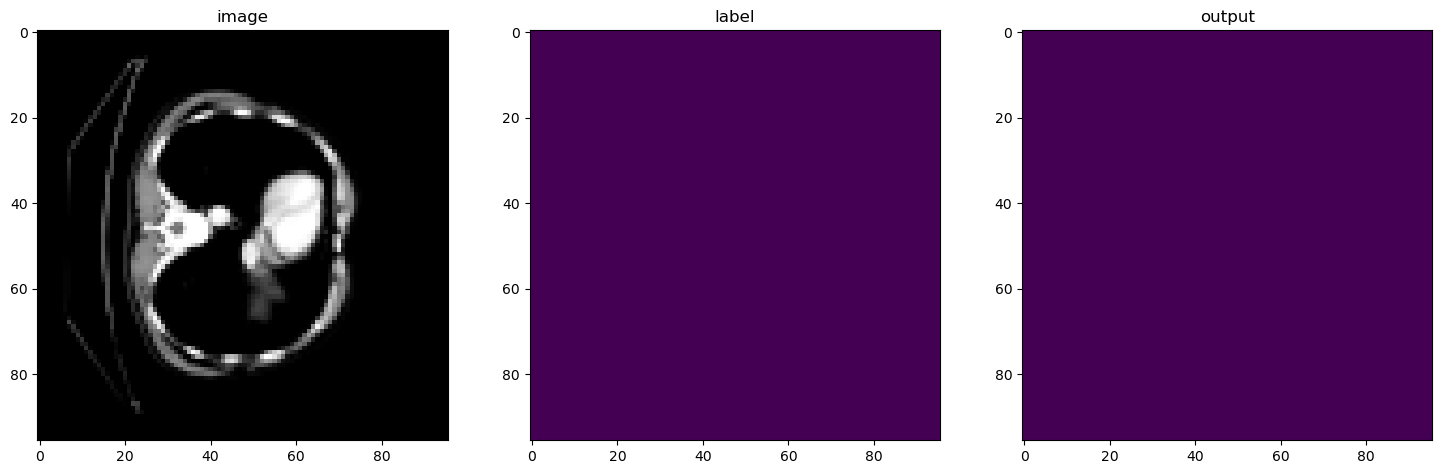

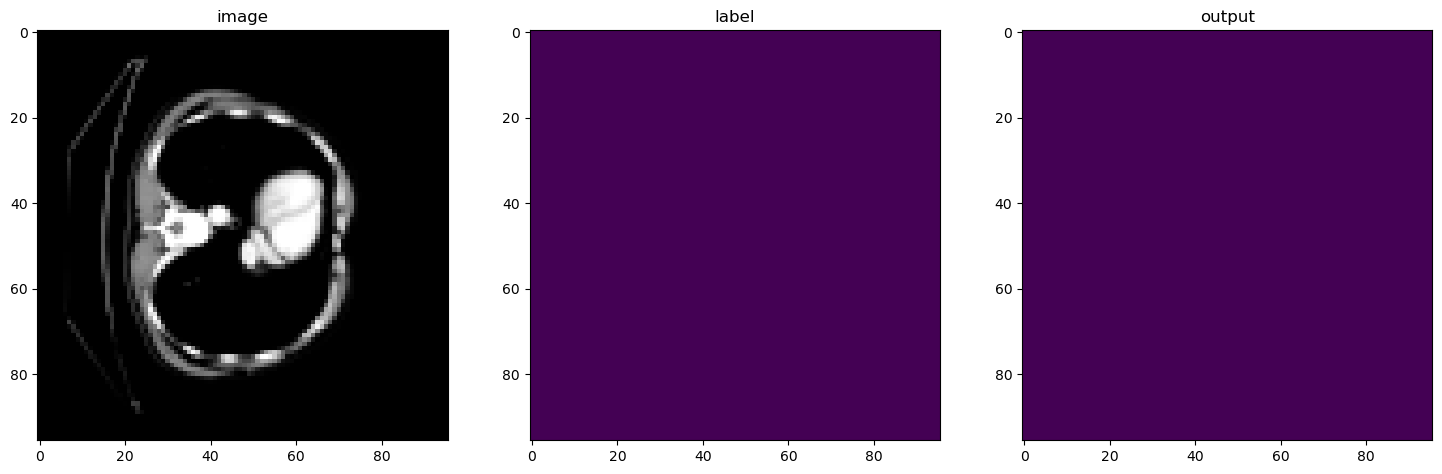

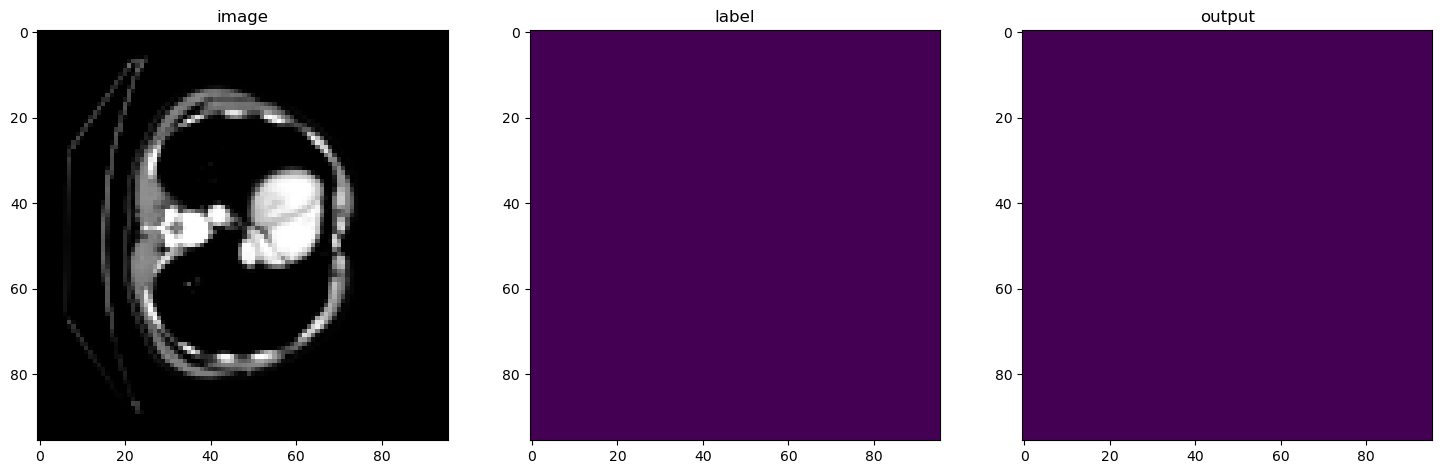

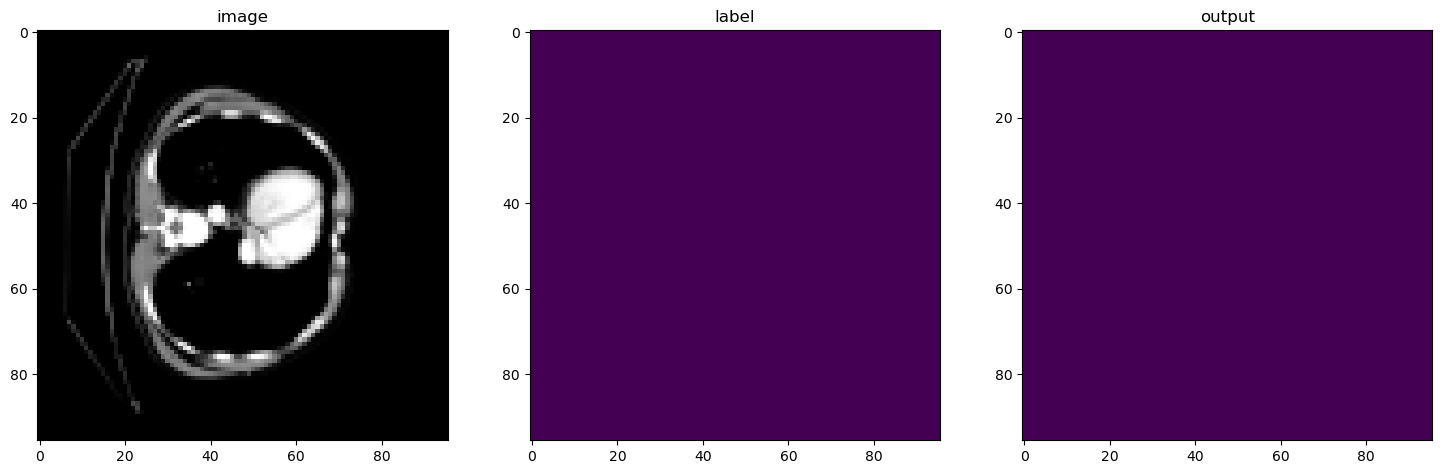

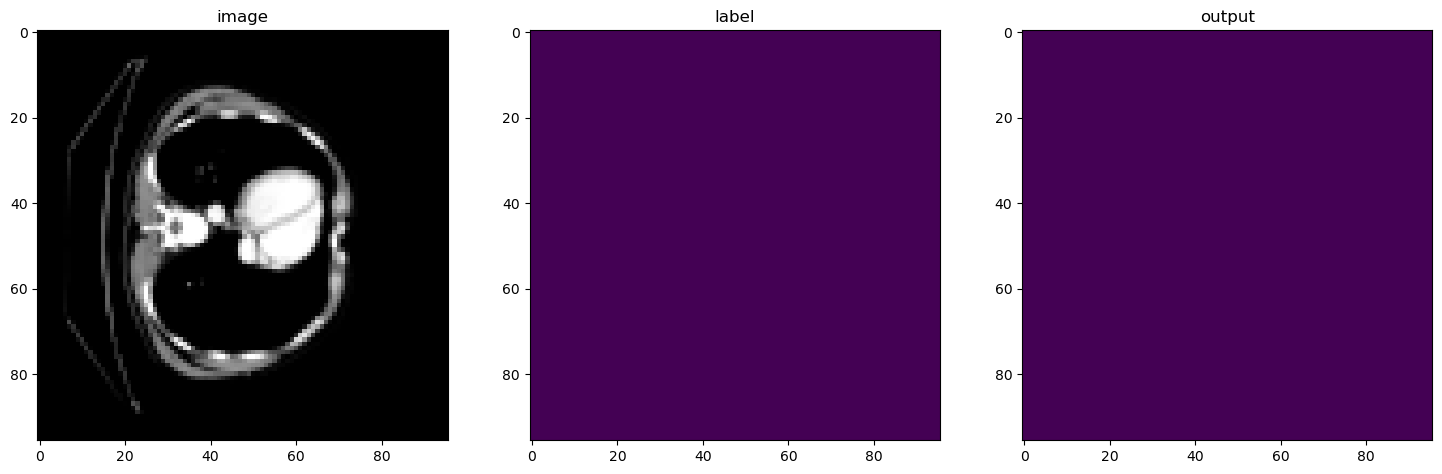

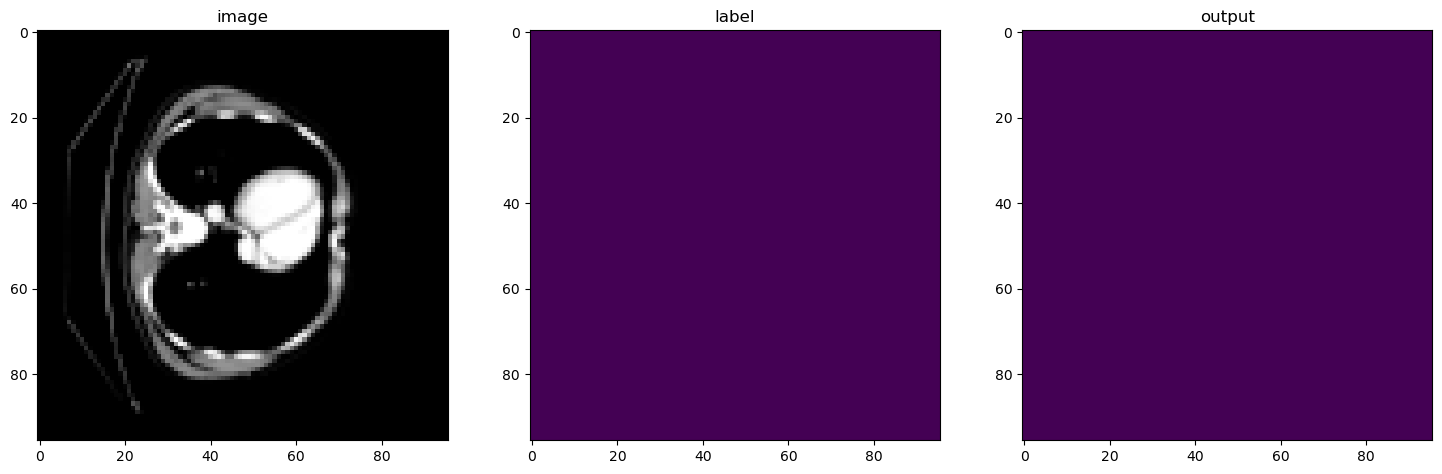

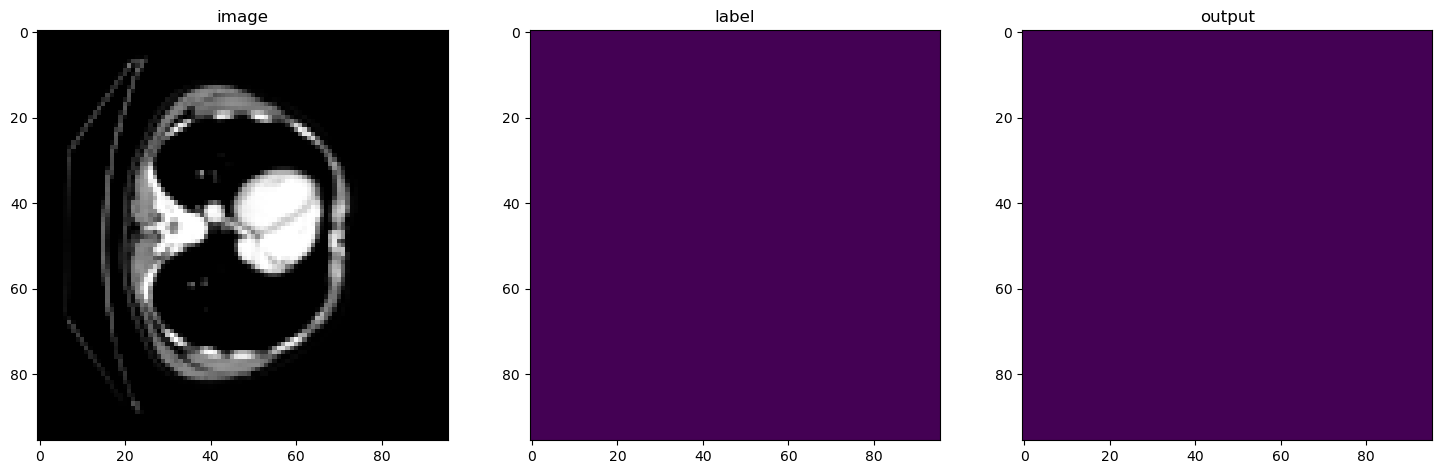

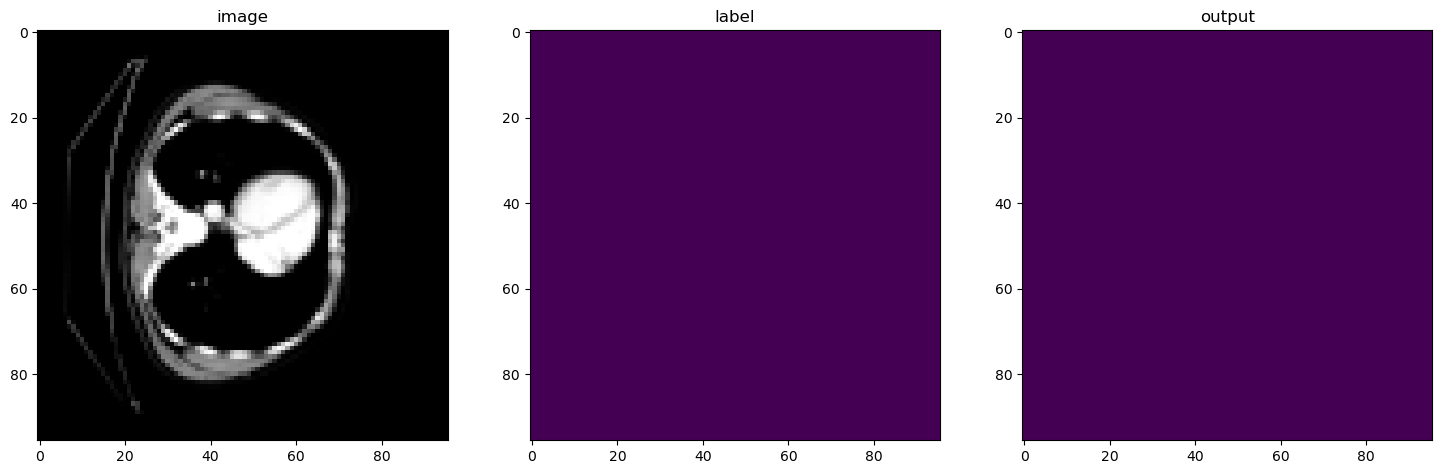

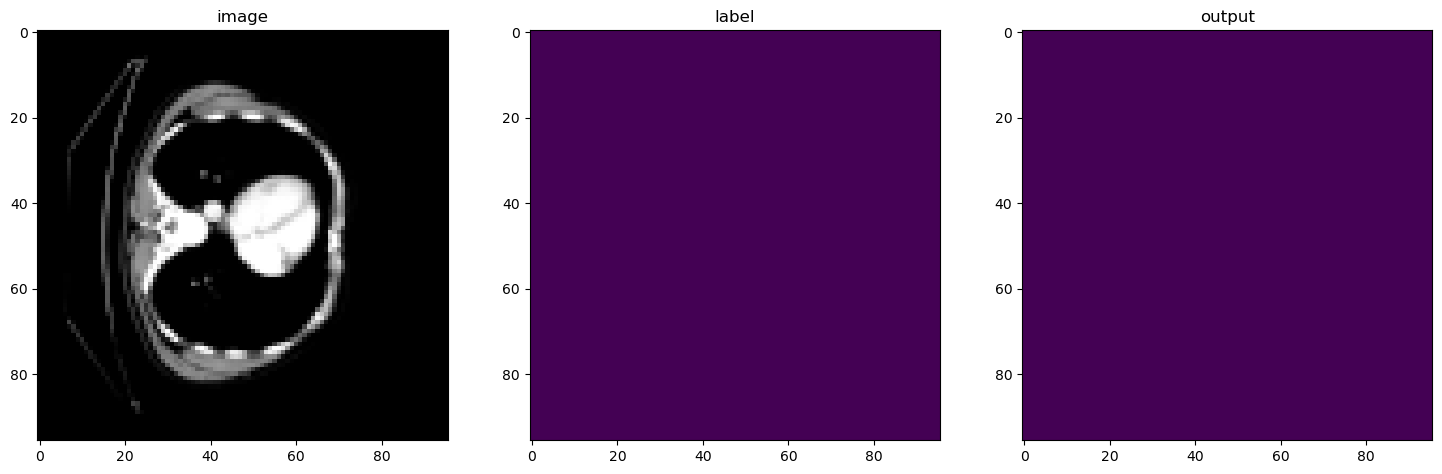

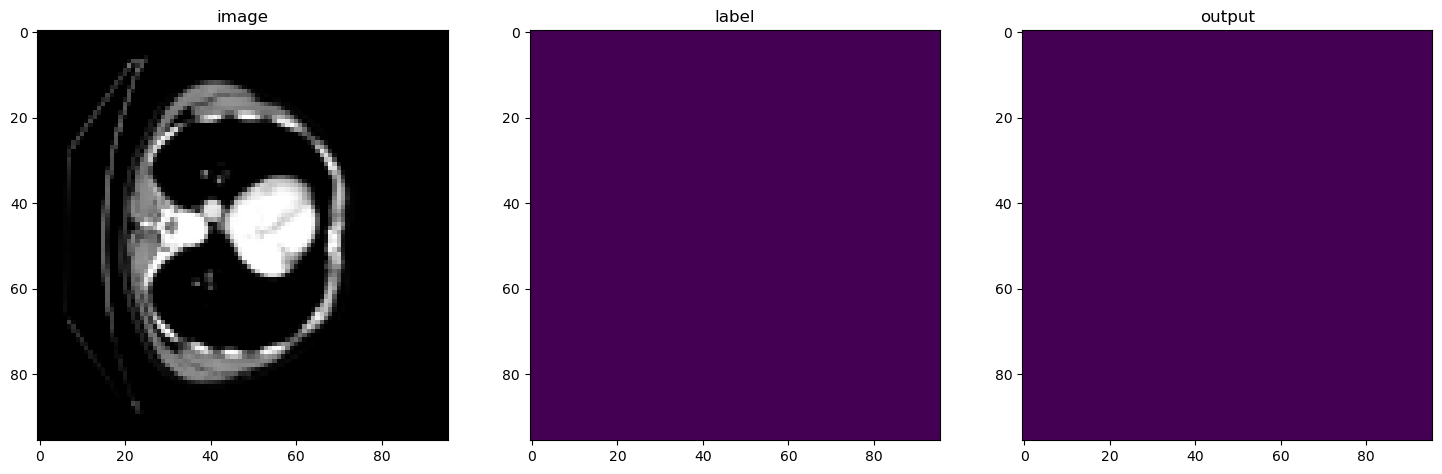

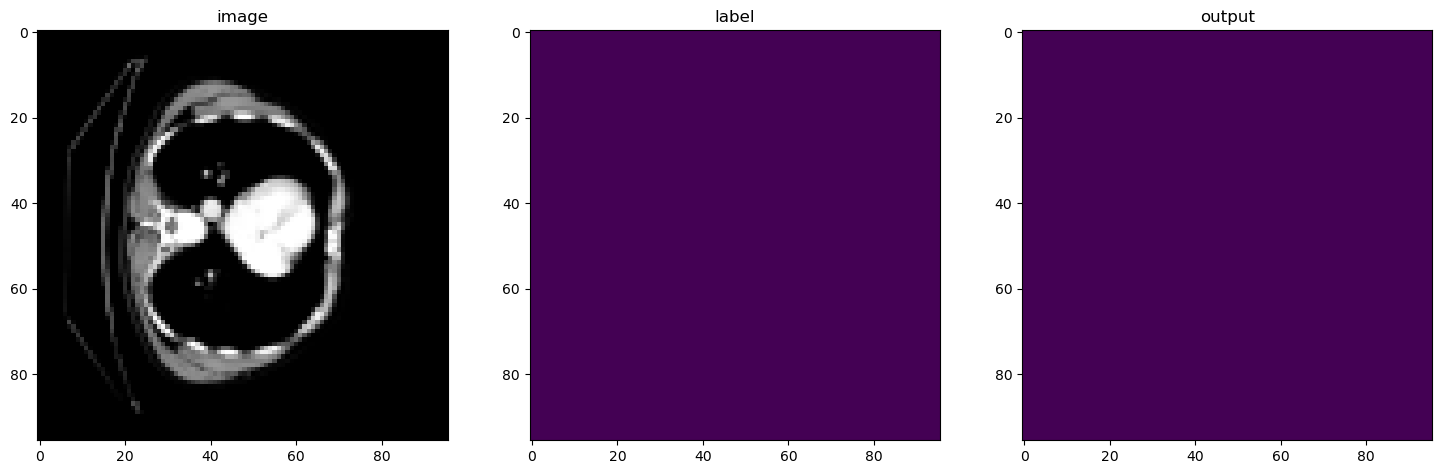

In [8]:
for layer in range(64):
    plt.figure('check', (18, 6))

    plt.subplot(1, 3, 1)
    plt.title('image')
    plt.imshow(data['image'][0, 0, :, :, layer], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('label')
    plt.imshow(label[:, :, layer])

    plt.subplot(1, 3, 3)
    plt.title('output')
    plt.imshow(valid_out[:, :, layer])

    plt.show()